## Supervised Learning notebook


In [54]:
import os
import json
import glob
import math
from datetime import datetime
from pathlib import Path
from typing import Dict, Tuple, Callable
from copy import deepcopy

## Environment
from dotenv import load_dotenv

## Core Scientific Stack
import numpy as np
import pandas as pd

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Database
import psycopg2

## Machine Learning / Preprocessing (scikit-learn)
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.inspection import permutation_importance

## Gradient Boosting Libraries
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from xgboost import XGBRegressor

## Deep Learning / Tabular
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from pytorch_tabnet.tab_model import TabNetRegressor

## Optimization & Persistence
import optuna
import joblib

# Load environment variables from .env file
load_dotenv(override=True)

# Setup model directory (handle notebook environment where __file__ is undefined)
try:
    PROJECT_ROOT = Path(__file__).resolve().parent
except NameError:
    # Fallback: assume notebook is inside src; go up one directory if so
    cwd = Path.cwd().resolve()
    if (cwd / 'supervised.ipynb').exists() or (cwd / 'unsupervised.ipynb').exists():
        PROJECT_ROOT = cwd
    else:
        for parent in cwd.parents:
            if (parent / 'requirements.txt').exists() or (parent / 'README.md').exists():
                PROJECT_ROOT = parent / 'src'
                break
        else:
            PROJECT_ROOT = cwd  # final fallback

MODEL_DIR = (PROJECT_ROOT / '..' / 'supervised').resolve()
MODEL_DIR.mkdir(parents=True, exist_ok=True)
print(f"Models will be saved to: {MODEL_DIR}")

def save_model(model, name: str, extra: dict | None = None):
    """Utility to persist models and optional metadata alongside them.
    Saves model as joblib plus a companion JSON with metadata/hyperparams.
    For PyTorch models, saves state_dict separately to avoid pickling issues."""
    timestamp = datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')
    base_name = f"{name}_{timestamp}"
    
    # Check if this is a PyTorch-based model
    is_torch_model = hasattr(model, 'model_') and isinstance(model.model_, nn.Module)
    
    if is_torch_model:
        # Save PyTorch model state separately
        model_path = MODEL_DIR / f"{base_name}.pt"
        params_path = MODEL_DIR / f"{base_name}_params.json"
        
        # Save the model state dict and parameters
        torch.save({
            'model_state_dict': model.model_.state_dict(),
            'model_params': model.get_params(),
            'n_features_in': getattr(model, 'n_features_in_', None),
            'device': getattr(model, '_device_', 'cpu')
        }, model_path)
        
        # Save initialization parameters for recreation
        with open(params_path, 'w') as f:
            json.dump(model.get_params(), f, indent=2)
            
        print(f"Saved PyTorch model -> {model_path.name}; params -> {params_path.name}")
    else:
        # Use joblib for non-PyTorch models
        model_path = MODEL_DIR / f"{base_name}.joblib"
        joblib.dump(model, model_path)
        print(f"Saved model -> {model_path.name}")
    
    # Save metadata
    meta_path = MODEL_DIR / f"{base_name}.json"
    meta = {'model_name': name, 'saved_utc': timestamp, 'is_torch_model': is_torch_model}
    
    if extra:
        # Deep copy and convert non-serializable objects
        extra_clean = {}
        for k, v in extra.items():
            try:
                # Test if value is JSON serializable
                json.dumps(v)
                extra_clean[k] = v
            except TypeError:
                # Handle TabNet History objects and other non-serializable types
                if hasattr(v, 'history') and hasattr(v, 'epoch'):
                    # TabNet History object - extract the history dict
                    extra_clean[k] = getattr(v, 'history', {})
                elif hasattr(v, '__dict__'):
                    # Try to extract dict representation
                    try:
                        dict_repr = {attr: getattr(v, attr) for attr in dir(v) 
                                   if not attr.startswith('_') and not callable(getattr(v, attr))}
                        # Test if the dict is serializable
                        json.dumps(dict_repr)
                        extra_clean[k] = dict_repr
                    except (TypeError, AttributeError):
                        extra_clean[k] = str(v)  # Fallback to string representation
                else:
                    extra_clean[k] = str(v)  # Fallback to string representation
        meta.update(extra_clean)
    
    with open(meta_path, 'w') as f:
        json.dump(meta, f, indent=2)
    print(f"Saved metadata -> {meta_path.name}")

# Database connection parameters
db_params = {
    "host": os.getenv("LOCAL_HOST"),
    "user": os.getenv("LOCAL_USER"),
    "password": os.getenv("LOCAL_PW"),
    "port": os.getenv("LOCAL_PORT"),
    "dbname": os.getenv("LOCAL_DB")
}

# Check CUDA availability
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is NOT available - PyTorch will use CPU only")
# Display versions
print('LightGBM version:', lgb.__version__)
print('XGBoost version:', xgb.__version__)

Models will be saved to: D:\docs\MADS\696-Milestone 2\supervised
PyTorch version: 2.5.1
CUDA version: 12.1
Device name: NVIDIA GeForce GTX 1660 Ti
LightGBM version: 4.6.0
XGBoost version: 3.0.5


### TabNet Class Definitions (Early Load)
Define TabNet wrapper class here before auto-load cell to support unpickling saved models.

In [55]:
# TabNet wrapper class - defined early for joblib unpickling compatibility
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_is_fitted

def prepare_data_for_tabnet(X, y=None):
    """Convert data to TabNet-compatible format."""
    X_dense = X.toarray().astype(np.float32) if hasattr(X, 'toarray') else np.asarray(X, dtype=np.float32)
    if y is not None:
        y_arr = np.asarray(y)
        y_reshaped = y_arr.reshape(-1, 1) if y_arr.ndim == 1 else y_arr
        return X_dense, y_reshaped
    return X_dense

class SimpleTabNetWrapper(BaseEstimator, RegressorMixin):
    """Simplified TabNet wrapper with sensible defaults."""
    
    def __init__(self, n_d=16, n_a=16, n_steps=5, gamma=1.3, lambda_sparse=1e-4, 
                 lr=0.02, max_epochs=100, patience=20, batch_size=1024, seed=42):
        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.lambda_sparse = lambda_sparse
        self.lr = lr
        self.max_epochs = max_epochs
        self.patience = patience
        self.batch_size = batch_size
        self.seed = seed
        self.model_ = None

    def fit(self, X, y):
        from pytorch_tabnet.tab_model import TabNetRegressor
        
        X_prep, y_prep = prepare_data_for_tabnet(X, y)
        
        # Create internal validation split (15% for early stopping)
        n_samples = X_prep.shape[0]
        val_size = max(1, int(n_samples * 0.15))
        rng = np.random.default_rng(self.seed)
        indices = rng.permutation(n_samples)
        
        train_idx, val_idx = indices[val_size:], indices[:val_size]
        X_train, y_train = X_prep[train_idx], y_prep[train_idx]
        X_val, y_val = X_prep[val_idx], y_prep[val_idx]
        
        self.model_ = TabNetRegressor(
            n_d=self.n_d, n_a=self.n_a, n_steps=self.n_steps,
            gamma=self.gamma, lambda_sparse=self.lambda_sparse,
            optimizer_params={'lr': self.lr}, seed=self.seed
        )
        
        self.model_.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric=['rmse'],
            max_epochs=self.max_epochs,
            patience=self.patience,
            batch_size=self.batch_size,
            virtual_batch_size=128
        )
        self.history_ = self.model_.history
        return self

    def predict(self, X):
        check_is_fitted(self, 'model_')
        X_prep = prepare_data_for_tabnet(X)
        return self.model_.predict(X_prep).ravel()

print("✓ SimpleTabNetWrapper class defined")

✓ SimpleTabNetWrapper class defined


### Auto Load / Conditional Training
If a previously saved optimized model exists in `src/supervised`, the notebook will load the most recent artifact (by timestamp in filename) and skip retraining unless `FORCE_RETRAIN=True`.

In [56]:
# Auto-load previously saved optimized models (XGBoost / RandomForest / SVR / LinearRegression / Polynomial / MLP / TabNet)
from pathlib import Path as _Path
import json as _json

FORCE_RETRAIN = False
FAST_MODE = False
QUICK_TRIALS = 2 if FAST_MODE else 5  # Reduce Optuna trials
QUICK_EPOCHS = 80 if FAST_MODE else 100  # Reduce neural network epochs
QUICK_CV = 2 if FAST_MODE else 5  # Reduce cross-validation folds
USE_BASELINE_ONLY = False  # Skip hyperparameter optimization entirely

print(f"FAST_MODE: {FAST_MODE}")
print(f"Optuna trials: {QUICK_TRIALS}, Max epochs: {QUICK_EPOCHS}, CV folds: {QUICK_CV}")
print(f"Baseline only: {USE_BASELINE_ONLY}")

# Quick baseline parameters (no optimization)
BASELINE_PARAMS = {
    'xgb': {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1},
    'rf': {'n_estimators': 100, 'max_depth': 10, 'oob_score': True},
    'svr': {'kernel': 'rbf', 'C': 1.0, 'epsilon': 0.1},
    'mlp': {'hidden_layer_sizes': (128, 64), 'max_iter': 100, 'early_stopping': True},
    'tabnet': {'n_d': 16, 'n_a': 16, 'max_epochs': 50, 'patience': 10}
}

# Only set to None if not defined to avoid clobbering models loaded earlier in session
if 'xgb_model' not in globals():
    xgb_model = None
if 'rf_model' not in globals():
    rf_model = None
if 'mlp_model' not in globals():
    mlp_model = None
if 'tabnet_model' not in globals():
    tabnet_model = None  # Will delay loading until wrapper class defined
if 'svr_model' not in globals():
    svr_model = None
if 'lr_model' not in globals():
    lr_model = None
if 'poly_model' not in globals():
    poly_model = None

MODEL_GLOB_PATTERNS = {
    'xgb_model': 'xgboost_opt_*.joblib',
    'rf_model': 'random_forest_opt_*.joblib', 
    'mlp_model': 'mlp_opt_*.pt',  # Changed to .pt for PyTorch models
    'tabnet_model': 'tabnet_opt_*.joblib',  # Now loading TabNet here
    'svr_model': 'svr_opt_*.joblib',
    'lr_model': 'linear_regression_opt_*.joblib',
    'poly_model': 'poly_reg_opt_*.joblib'
}

loaded_flags = {}
for var, pattern in MODEL_GLOB_PATTERNS.items():
    if globals().get(var) is not None:
        loaded_flags[var] = 'pre-existing'
        continue
    matches = list(MODEL_DIR.glob(pattern))
    if not matches:
        loaded_flags[var] = 'not found'
        continue
    # Sort by modification time to get the truly latest file
    latest = max(matches, key=lambda p: p.stat().st_mtime)
    try:
        # Special handling for PyTorch models
        if pattern.endswith('.pt'):
            # Load PyTorch model state
            checkpoint = torch.load(latest, map_location='cpu')
            model_params = checkpoint['model_params']
            
            # Recreate the model (assumes TorchMLPRegressor class is defined)
            if 'mlp' in var:
                from sklearn.base import BaseEstimator, RegressorMixin
                # Model will be recreated when needed - just store params for now
                globals()[f"{var}_params"] = model_params
                globals()[f"{var}_checkpoint"] = checkpoint
                loaded_flags[var] = f"✓ {latest.name} (PyTorch checkpoint)"
                print(f" {var}: {latest} (will be recreated on use)")
                globals()[var] = None  # Will recreate later
                continue
        
        # Standard joblib loading (skip TabNet if it will fail)
        if 'tabnet' in var:
            # Check metadata first to see if it's compatible
            meta_file = latest.with_suffix('.json')
            if meta_file.exists():
                with open(meta_file) as f:
                    meta = _json.load(f)
                model_type = meta.get('model_type', 'unknown')
                # Only load if it's the correct wrapper class
                if model_type != 'SimpleTabNetWrapper':
                    loaded_flags[var] = f'skipped (old class: {model_type})'
                    globals()[var] = None
                    print(f" {var}: Skipping incompatible model ({model_type}), will retrain")
                    continue
        
        globals()[var] = joblib.load(latest)
        meta_file = latest.with_suffix('.json')
        if meta_file.exists():
            with open(meta_file) as f:
                globals()[f"{var}_meta"] = _json.load(f)
        # Show the actual file that was loaded
        loaded_flags[var] = f"✓ {latest.name}"
        print(f"  {var}: {latest}")
    except Exception as e:
        loaded_flags[var] = f"failed: {e}";
        globals()[var] = None

print("\nAuto-load status:")
for k,v in loaded_flags.items():
    print(f"  {k}: {v}")
print(f"\nFORCE_RETRAIN = {FORCE_RETRAIN}")

FAST_MODE: False
Optuna trials: 5, Max epochs: 100, CV folds: 5
Baseline only: False

Auto-load status:
  xgb_model: pre-existing
  rf_model: pre-existing
  mlp_model: pre-existing
  tabnet_model: pre-existing
  svr_model: pre-existing
  lr_model: pre-existing
  poly_model: pre-existing

FORCE_RETRAIN = False


In [57]:
# Connect to database and load data
try:
    conn = psycopg2.connect(**db_params)
    print("Database connection successful")
    sql_query = "SELECT * FROM dev.base_data;"
    df = pd.read_sql_query(sql_query, conn)
    conn.close()
    
    # SPEED OPTIMIZATION: Sample data for faster training
    if FAST_MODE and len(df) > 1000:
        sample_size = min(1000, len(df))
        df = df.sample(n=sample_size, random_state=42)
        print(f"FAST_MODE: Sampled {sample_size} rows from {len(df)} total rows")
    
    print(f"Golden data loaded into DataFrame: {df.shape}")
except Exception as e:
    print(f"An error occurred: {e}")

Database connection successful


pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


Golden data loaded into DataFrame: (23038, 18)


## 3. Data Splitting: Train, Validation, Test
Split the dataset into train, validation, and test sets, ensuring proper handling of the target variable.

In [58]:
# Define target and drop missing
TARGET = 'math_high_pct' if 'math_high_pct' in df.columns else 'target'
data = df.dropna().reset_index(drop=True)
data = data.set_index('school_name')

# Split features and target
feature_cols = [c for c in data.columns if c != TARGET 
                and c != 'dup_rank' 
                and c != 'math_low_pct' 
                and c != 'reading_low_pct' 
                and c != 'match_']
X = data[feature_cols]
y = data[TARGET]

# Train/validation/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.40, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
print(f'Train shape: {X_train.shape}, Validation shape: {X_valid.shape}, Test shape: {X_test.shape}')

Train shape: (12378, 15), Validation shape: (4126, 15), Test shape: (4126, 15)


## 4. Feature Engineering and Preprocessing Pipeline
Identify numeric and categorical features, set up StandardScaler and OneHotEncoder, and build a ColumnTransformer pipeline.

In [59]:
# Identify numeric and categorical features
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=['category', 'object']).columns.tolist()

print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# Fit preprocessor
preprocessor.fit(X_train)
X_train_enc = preprocessor.transform(X_train)
X_valid_enc = preprocessor.transform(X_valid)
X_test_enc = preprocessor.transform(X_test)

Numeric features: ['teachers_fte', 'enrollment', 'grade_eight_enrollment', 'math_counts', 'read_counts', 'read_high_pct', 'pct_hhi_150k_200k', 'pct_hhi_220k_plus', 'avg_natwalkind', 'total_10_14', 'pct_10_14', 'pct_female_10_14', 'total_pop', 'schools_in_zip']
Categorical features: ['school_type']


## Model Optimization function

This is the key of my hyperparameter tunning machine. This study generator helps with a framework to add search space parameters that are unique to each model. 

In [60]:
# Reusable Optuna-based optimizer for cross-validated hyperparameter tuning
from typing import Callable, Dict, Tuple

def optimize_model_with_optuna(
                                model_name: str,
                                estimator_builder: Callable[[Dict], object],
                                param_space_fn: Callable[[optuna.trial.Trial], Dict],
                                X,
                                y,
                                scoring: str = 'neg_root_mean_squared_error',
                                cv: int = 3,
                                n_trials: int = 5,
                                direction: str = 'minimize',
                                random_state: int = 42,
                                n_jobs: int = -1,
                            ) -> Tuple[optuna.study.Study, Dict]:
    """Optimize a model's hyperparameters using Optuna and cross-validation.

    Args:
        model_name: Name used to label the Optuna study
        estimator_builder: Callable that receives a params dict and returns an unfitted estimator
        param_space_fn: Callable that maps an Optuna trial to a hyperparameter dictionary
        X, y: Training features and targets used for cross-validation
        scoring: scikit-learn scoring string guiding optimization
        cv: Number of cross-validation folds
        n_trials: Number of trials to run
        direction: 'minimize' or 'maximize' depending on the objective
        random_state: Seed for the Optuna sampler
        n_jobs: Parallelism

    Returns:
        The completed Optuna study and the best hyperparameters.
    """
    sampler = optuna.samplers.TPESampler(seed=random_state)
    study = optuna.create_study(study_name=f"{model_name}_opt", direction=direction, sampler=sampler)

    def objective(trial: optuna.trial.Trial) -> float:
        params = param_space_fn(trial)
        estimator = estimator_builder(params)
        scores = cross_val_score(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs)
        mean_score = np.mean(scores)
        normalized_score = -mean_score if scoring.startswith('neg') else mean_score
        return normalized_score if direction == 'minimize' else -normalized_score

    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    return study, study.best_params

## LINEAR MODELS

In [61]:
# Manual learning curve function for sklearn models
def get_sklearn_learning_curve(model, X_train, y_train, X_valid, y_valid, n_steps=10):
    train_errors, val_errors = [], []
    train_sizes = np.linspace(0.1, 1.0, n_steps)
    
    for train_size in train_sizes:
        n_samples = int(train_size * len(X_train))
        if n_samples < 1: continue
            
        X_train_subset, y_train_subset = X_train[:n_samples], y_train[:n_samples]
        
        model.fit(X_train_subset, y_train_subset)
        
        train_pred = model.predict(X_train_subset)
        val_pred = model.predict(X_valid)
        
        train_errors.append(np.sqrt(mean_squared_error(y_train_subset, train_pred)))
        val_errors.append(np.sqrt(mean_squared_error(y_valid, val_pred)))
        
    return {
        'train_rmse': train_errors, 
        'val_rmse': val_errors, 
        'train_sizes': train_sizes.tolist()
        }

# Linear & Kernel-based Models: SVR + Polynomial Regression (with Optuna tuning + CV)
def build_svr_estimator(params: Dict) -> SVR:
    base = {'kernel': params.get('kernel', 'rbf')}
    # Map params safely
    for k in ['C','epsilon','gamma','degree']:
        if k in params:
            base[k] = params[k]
    return SVR(**base)

def svr_param_space(trial: optuna.trial.Trial) -> Dict:
    kernel = trial.suggest_categorical('kernel', ['rbf','poly','sigmoid'])
    params = {
        'kernel': kernel,
        'C': trial.suggest_float('C', 0.5, 10, log=True),
        'epsilon': trial.suggest_float('epsilon', 0.05, 0.3),
    }
    if kernel in ['rbf','sigmoid']:
        params['gamma'] = trial.suggest_float('gamma', 0.1, 0.5, log=True)
    if kernel == 'poly':
        params['degree'] = trial.suggest_int('degree', 2, 5)
        params['gamma'] = trial.suggest_float('gamma', 0.1, 1, log=True)
    return params

# Run / reuse SVR optimization
if svr_model is None or FORCE_RETRAIN:
    print('[SVR] Starting Optuna optimization...')
    svr_study, svr_best_params = optimize_model_with_optuna(
        model_name='SVR',
        estimator_builder=build_svr_estimator,
        param_space_fn=svr_param_space,
        X=X_train_enc,
        y=y_train,
        scoring='neg_root_mean_squared_error',
        cv=QUICK_CV,
        n_trials=QUICK_TRIALS,
        direction='minimize',
        random_state=42,
        n_jobs=-1,
    )
    print('Best SVR params:', svr_best_params)
    svr_model = build_svr_estimator(svr_best_params)
    svr_model.fit(X_train_enc, y_train)
    svr_learning_curves = get_sklearn_learning_curve(svr_model, X_train_enc, y_train, X_valid_enc, y_valid)
    svr_valid_pred = svr_model.predict(X_valid_enc)
    svr_test_pred = svr_model.predict(X_test_enc)
    save_model(svr_model, 'svr_opt', {'best_params': svr_best_params, 'learning_curves': svr_learning_curves})
else:
    print('[SVR] Using preloaded optimized model; generating predictions.')
    svr_learning_curves = get_sklearn_learning_curve(svr_model, X_train_enc, y_train, X_valid_enc, y_valid)
    svr_valid_pred = svr_model.predict(X_valid_enc)
    svr_test_pred = svr_model.predict(X_test_enc)
    save_model(svr_model, 'svr_opt_refit', {'refit': True, 'learning_curves': svr_learning_curves})


# Baseline Linear Regression (also optionally re-optimized via polynomial)
if lr_model is None or FORCE_RETRAIN:
    # Keep a simple baseline linear regression for reference
    lr_model = LinearRegression()
    lr_model.fit(X_train_enc, y_train)
    lr_learning_curves = get_sklearn_learning_curve(lr_model, X_train_enc, y_train, X_valid_enc, y_valid)
    save_model(lr_model, 'linear_regression_opt', {'params': lr_model.get_params(), 'baseline': True, 'learning_curves': lr_learning_curves})
    lr_valid_pred = lr_model.predict(X_valid_enc)
    lr_test_pred = lr_model.predict(X_test_enc)
elif lr_model is not None:
    lr_learning_curves = get_sklearn_learning_curve(lr_model, X_train_enc, y_train, X_valid_enc, y_valid)
    lr_valid_pred = lr_model.predict(X_valid_enc)
    lr_test_pred = lr_model.predict(X_test_enc)
    save_model(lr_model, 'linear_regression_opt_refit', {'refit': True, 'learning_curves': lr_learning_curves})

[SVR] Using preloaded optimized model; generating predictions.
Saved model -> svr_opt_refit_20251020T143634Z.joblib
Saved metadata -> svr_opt_refit_20251020T143634Z.json
Saved model -> linear_regression_opt_refit_20251020T143634Z.joblib
Saved metadata -> linear_regression_opt_refit_20251020T143634Z.json


# NEURAL NETWORKS

### Note on PyTorch Model Persistence
PyTorch models are saved using `torch.save()` with `.pt` extension instead of joblib to avoid pickling issues in notebooks. The model state dict and parameters are saved separately and can be restored by recreating the model architecture and loading the weights.

## MLP

In [62]:
# Torch MLP Regressor with sklearn API
def _ensure_dense_np(X):
    return X.toarray() if hasattr(X, 'toarray') else X

class TorchMLPRegressor(BaseEstimator, RegressorMixin):
    """PyTorch MLP for regression with sklearn API and CUDA support."""
    
    def __init__(self, hidden_layer_sizes=(128, 64), activation='relu', 
                 learning_rate_init=1e-3, alpha=0.0, batch_size=128, max_iter=100,
                 early_stopping=True, validation_fraction=0.1, n_iter_no_change=10,
                 random_state=42, verbose=False, device=None):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.learning_rate_init = learning_rate_init
        self.alpha = alpha
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.early_stopping = early_stopping
        self.validation_fraction = validation_fraction
        self.n_iter_no_change = n_iter_no_change
        self.random_state = random_state
        self.verbose = verbose
        self.device = device

    def _build_network(self, in_features):
        layers = []
        act_fn = nn.ReLU if self.activation == 'relu' else nn.Tanh
        prev = in_features
        for h in self.hidden_layer_sizes:
            layers.extend([nn.Linear(prev, h), act_fn()])
            prev = h
        layers.append(nn.Linear(prev, 1))
        return nn.Sequential(*layers)

    def fit(self, X, y):
        # Setup
        torch.manual_seed(self.random_state)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(self.random_state)
        
        X_np = _ensure_dense_np(X).astype('float32')
        y_np = (y.values if hasattr(y, 'values') else y).astype('float32').reshape(-1, 1)
        
        # Train/val split
        if self.early_stopping and 0 < self.validation_fraction < 0.5:
            val_size = max(1, int(len(X_np) * self.validation_fraction))
            idx = np.random.RandomState(self.random_state).permutation(len(X_np))
            X_train, X_val = X_np[idx[val_size:]], X_np[idx[:val_size]]
            y_train, y_val = y_np[idx[val_size:]], y_np[idx[:val_size]]
        else:
            X_train, y_train, X_val, y_val = X_np, y_np, None, None
        
        # Device and model
        device = self.device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self._device_ = device
        self.model_ = self._build_network(X_np.shape[1]).to(device)
        self.optimizer_ = torch.optim.Adam(self.model_.parameters(), 
                                          lr=self.learning_rate_init, 
                                          weight_decay=self.alpha)
        criterion = nn.MSELoss()
        
        # Training
        train_loader = DataLoader(
            TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)),
            batch_size=self.batch_size, shuffle=True
        )
        
        best_val, best_state, patience = math.inf, None, 0
        for epoch in range(1, self.max_iter + 1):
            self.model_.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                self.optimizer_.zero_grad()
                criterion(self.model_(xb), yb).backward()
                self.optimizer_.step()
            
            # Validation
            if X_val is not None:
                self.model_.eval()
                with torch.no_grad():
                    val_loss = criterion(
                        self.model_(torch.from_numpy(X_val).to(device)),
                        torch.from_numpy(y_val).to(device)
                    ).item()
                
                if val_loss < best_val - 1e-9:
                    best_val, patience = val_loss, 0
                    best_state = {k: v.cpu().clone() for k, v in self.model_.state_dict().items()}
                else:
                    patience += 1
                
                if patience >= self.n_iter_no_change:
                    break
        
        if best_state:
            self.model_.load_state_dict(best_state)
        self.n_features_in_ = X_np.shape[1]
        return self

    def predict(self, X):
        check_is_fitted(self, ['model_'])
        X_np = _ensure_dense_np(X).astype('float32')
        self.model_.eval()
        with torch.no_grad():
            preds = self.model_(torch.from_numpy(X_np).to(self._device_))
        return preds.cpu().numpy().ravel()

# Helper functions
def build_mlp_estimator(params):
    params = params.copy()
    params.pop('hl1', None)
    params.pop('hl2', None)
    return TorchMLPRegressor(**params)

def mlp_param_space(trial):
    return {
        'hidden_layer_sizes': tuple(sorted([
            trial.suggest_int('hl1', 64, 256, step=32),
            trial.suggest_int('hl2', 32, 192, step=32)
        ], reverse=True)),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-2, log=True),
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256]),
        'max_iter': trial.suggest_int('max_iter', QUICK_EPOCHS//2, QUICK_EPOCHS, step=25),
        'n_iter_no_change': trial.suggest_int('n_iter_no_change', 5, 15, step=5),
        'early_stopping': True,
        'validation_fraction': 0.15,
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh']),
        'random_state': 42,
        'verbose': False,
    }

# Training
if mlp_model is None or FORCE_RETRAIN:
    # Check if we have a saved checkpoint to restore from
    if 'mlp_model_checkpoint' in globals() and mlp_model is None and not FORCE_RETRAIN:
        checkpoint = mlp_model_checkpoint
        saved_n_features = checkpoint['n_features_in']
        current_n_features = X_train_enc.shape[1]
        
        # Validate feature count matches
        if saved_n_features != current_n_features:
            print(f"[MLP] Feature mismatch: saved model has {saved_n_features} features, current data has {current_n_features}")
            print(f"[MLP] Cannot restore checkpoint - will retrain from scratch")
            mlp_model = None  # Force retraining
        else:
            print("[MLP] Restoring from PyTorch checkpoint")
            mlp_model = build_mlp_estimator(checkpoint['model_params'])
            
            # Determine device (prefer CUDA if available)
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            mlp_model._device_ = device
            
            # Manually restore the internal state
            mlp_model.model_ = mlp_model._build_network(checkpoint['n_features_in']).to(device)
            mlp_model.model_.load_state_dict(checkpoint['model_state_dict'])
            mlp_model.n_features_in_ = checkpoint['n_features_in']
            
            print(f"[MLP] Restored model to device: {device}")
            mlp_valid_pred = mlp_model.predict(X_valid_enc)
            mlp_test_pred = mlp_model.predict(X_test_enc)
    
    # Train from scratch if no checkpoint or checkpoint invalid
    if mlp_model is None:
        print(f"[MLP] Starting optimization on {'CUDA' if torch.cuda.is_available() else 'CPU'}")
        mlp_study, mlp_best_params = optimize_model_with_optuna(
            model_name='TorchMLPRegressor',
            estimator_builder=build_mlp_estimator,
            param_space_fn=mlp_param_space,
            X=X_train_enc, y=y_train,
            scoring='neg_root_mean_squared_error',
            cv=QUICK_CV, 
            n_trials=QUICK_TRIALS, 
            direction='minimize',
            random_state=42, n_jobs=-1,
        )
        print(f'[MLP] Best params: {mlp_best_params}')
        mlp_model = build_mlp_estimator(mlp_best_params)
        mlp_model.fit(X_train_enc, y_train)
        mlp_valid_pred = mlp_model.predict(X_valid_enc)
        mlp_test_pred = mlp_model.predict(X_test_enc)
        save_model(mlp_model, 'mlp_opt', {'best_params': mlp_best_params, 'framework': 'torch'})
else:
    print("[MLP] Refitting preloaded model")
    mlp_model.fit(X_train_enc, y_train)
    mlp_valid_pred = mlp_model.predict(X_valid_enc)
    mlp_test_pred = mlp_model.predict(X_test_enc)
    save_model(mlp_model, 'mlp_opt_refit', {'refit': True, 'framework': 'torch'})


[MLP] Refitting preloaded model
Saved PyTorch model -> mlp_opt_refit_20251020T143646Z.pt; params -> mlp_opt_refit_20251020T143646Z_params.json
Saved metadata -> mlp_opt_refit_20251020T143646Z.json


## TABNET

In [63]:
# Simplified TabNet Implementation
os.environ.setdefault("OMP_NUM_THREADS", "1")
try:
    torch.set_num_threads(1)
except Exception:
    pass

def get_tabnet_param_space(trial):
    """Parameter space for TabNet optimization."""
    quick_epochs = globals().get('QUICK_EPOCHS', 80)
    return {
        'n_d': trial.suggest_categorical('n_d', [8, 16, 24]),
        'n_a': trial.suggest_categorical('n_a', [8, 16, 24]),
        'n_steps': trial.suggest_int('n_steps', 3, 6),
        'gamma': trial.suggest_float('gamma', 1.0, 1.8),
        'lambda_sparse': trial.suggest_float('lambda_sparse', 0.001, 0.01, log=True),
        'lr': trial.suggest_float('lr', 1e-3, 2e-2, log=True),
        'max_epochs': quick_epochs,
        'patience': min(20, quick_epochs//4)
    }

def load_or_train_tabnet():
    """Load existing TabNet model or train new one with error handling."""

    # Check for pre-loaded model from auto-load cell
    if 'tabnet_model' in globals() and tabnet_model is not None and not FORCE_RETRAIN:
        if isinstance(tabnet_model, SimpleTabNetWrapper):
            print("[TabNet] Using pre-loaded model")
            save_model(tabnet_model, 'tabnet_opt_refit', {
                'refit': True,
                'learning_curves': getattr(tabnet_model, 'history_', None),
                'model_type': 'SimpleTabNetWrapper'
            })
            return tabnet_model
        else:
            print(f"[TabNet] Pre-loaded model type mismatch ({type(tabnet_model).__name__}), retraining")

    # Try to load saved model from disk
    tabnet_files = sorted(MODEL_DIR.glob('tabnet_opt_*.joblib'))
    if tabnet_files and not FORCE_RETRAIN:
        try:
            model = joblib.load(tabnet_files[-1])
            if isinstance(model, SimpleTabNetWrapper):
                print(f"[TabNet] Loaded saved model: {tabnet_files[-1].name}")
                save_model(model, 'tabnet_opt_refit', {
                    'refit': True,
                    'learning_curves': getattr(model, 'history_', None),
                    'model_type': 'SimpleTabNetWrapper'
                })
                return model
        except Exception as e:
            print(f"[TabNet] Failed to load saved model: {e}")

    # Train new model
    print("TabNet: Training...")
    try:
        quick_cv = globals().get('QUICK_CV', 2)
        quick_trials = globals().get('QUICK_TRIALS', 2)

        study, best_params = optimize_model_with_optuna(
            model_name='TabNetRegressor',
            estimator_builder=lambda params: SimpleTabNetWrapper(**params),
            param_space_fn=get_tabnet_param_space,
            X=X_train_enc, y=y_train,
            scoring='neg_root_mean_squared_error',
            cv=quick_cv, n_trials=quick_trials,
            direction='minimize', random_state=42, n_jobs=1
        )
    except Exception:
        best_params = {
            'n_d': 16, 'n_a': 16, 'n_steps': 5, 'gamma': 1.3,
            'lambda_sparse': 1e-4, 'lr': 0.01, 'max_epochs': 80, 'patience': 20
        }

    model = SimpleTabNetWrapper(**best_params)
    model.fit(X_train_enc, y_train)
    save_model(model, 'tabnet_opt', {
        'best_params': best_params,
        'learning_curves': model.history_,
        'model_type': 'SimpleTabNetWrapper'
    })
    print("[TabNet] Training complete")
    return model

# Execute TabNet training/loading
tabnet_model = load_or_train_tabnet()
tabnet_learning_curves = getattr(tabnet_model, 'history_', None)

# Generate predictions
tabnet_valid_pred = tabnet_model.predict(X_valid_enc)
tabnet_test_pred = tabnet_model.predict(X_test_enc)

[TabNet] Pre-loaded model type mismatch (SimpleTabNetWrapper), retraining
[TabNet] Loaded saved model: tabnet_opt_refit_20251018T221903Z.joblib
Saved model -> tabnet_opt_refit_20251020T143646Z.joblib
Saved metadata -> tabnet_opt_refit_20251020T143646Z.json


# 5. Tree-based ensemble models

## XGBOOST

In [64]:
# Hyperparameter optimization and training for ensemble models
def build_xgb_estimator(params: Dict) -> XGBRegressor:
    base_params = {
        'random_state': 42,
        'device': 'cuda',
        'verbosity': 0,
        'tree_method': 'gpu_hist'
    }
    base_params.update(params)
    return XGBRegressor(**base_params)

def xgb_param_space(trial: optuna.trial.Trial) -> Dict:
    return {
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.8),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1e-1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10, log=True)
    }

if xgb_model is None or FORCE_RETRAIN:
    print("[XGBoost] No preloaded model (or FORCE_RETRAIN=True). Starting Optuna optimization...")
    xgb_study, xgb_best_params = optimize_model_with_optuna(
        model_name='XGBoost',
        estimator_builder=build_xgb_estimator,
        param_space_fn=xgb_param_space,
        X=X_train_enc,
        y=y_train,
        scoring='neg_root_mean_squared_error',
        cv=QUICK_CV,
        n_trials=QUICK_TRIALS,
        direction='minimize',
        random_state=42,
        n_jobs=-1
    )
    print('Best XGBoost params:', xgb_best_params)
    # Fit model with optimized hyperparameters
    xgb_model = build_xgb_estimator(xgb_best_params)
    
    # New: Capture learning curves during fit
    eval_set = [(X_train_enc, y_train), (X_valid_enc, y_valid)]
    xgb_model.fit(X_train_enc, y_train, eval_set=eval_set, verbose=False)
    xgb_learning_curves = xgb_model.evals_result()

    xgb_valid_pred = xgb_model.predict(X_valid_enc)
    xgb_test_pred = xgb_model.predict(X_test_enc)
    save_model(xgb_model, 'xgboost_opt', {'best_params': xgb_best_params, 'learning_curves': xgb_learning_curves})
else:
    # Refit even when preloaded to ensure alignment with current data & preprocessing
    print('[XGBoost] Preloaded model found; refitting on current data.')
    # Try to pull previously stored best params from metadata if available
    reuse_params = None
    try:
        if 'xgb_model_meta' in globals() and isinstance(xgb_model_meta, dict):
            reuse_params = xgb_model_meta.get('best_params')
    except Exception:
        reuse_params = None
    if reuse_params is None:
        # Fall back to current model's parameters (filter to search space + core)
        try:
            current = xgb_model.get_params()
            reuse_keys = {'n_estimators','max_depth','learning_rate','subsample','colsample_bytree','reg_alpha','reg_lambda'}
            reuse_params = {k: v for k, v in current.items() if k in reuse_keys}
        except Exception:
            reuse_params = {}
    # Rebuild a fresh estimator to avoid any internal state carry-over
    xgb_model = build_xgb_estimator(reuse_params)
    
    # New: Capture learning curves during fit
    eval_set = [(X_train_enc, y_train), (X_valid_enc, y_valid)]
    xgb_model.fit(X_train_enc, y_train, eval_set=eval_set, verbose=False)
    xgb_learning_curves = xgb_model.evals_result()

    xgb_valid_pred = xgb_model.predict(X_valid_enc)
    xgb_test_pred = xgb_model.predict(X_test_enc)
    # Save refit artifact
    save_model(xgb_model, 'xgboost_opt_refit', {'refit': True, 'best_params': reuse_params, 'learning_curves': xgb_learning_curves})

[XGBoost] Preloaded model found; refitting on current data.
Saved model -> xgboost_opt_refit_20251020T143648Z.joblib
Saved metadata -> xgboost_opt_refit_20251020T143648Z.json


## XGBoost Tree Visualization

Visualize individual decision trees from the XGBoost ensemble to understand the model's decision-making process.

Creating MINIMAL, super legible tree visualization...

XGBOOST TREE 0: HORIZONTAL VIEW (Left → Right)


The `num_trees` parameter is deprecated, use `tree_idx` insetad. 


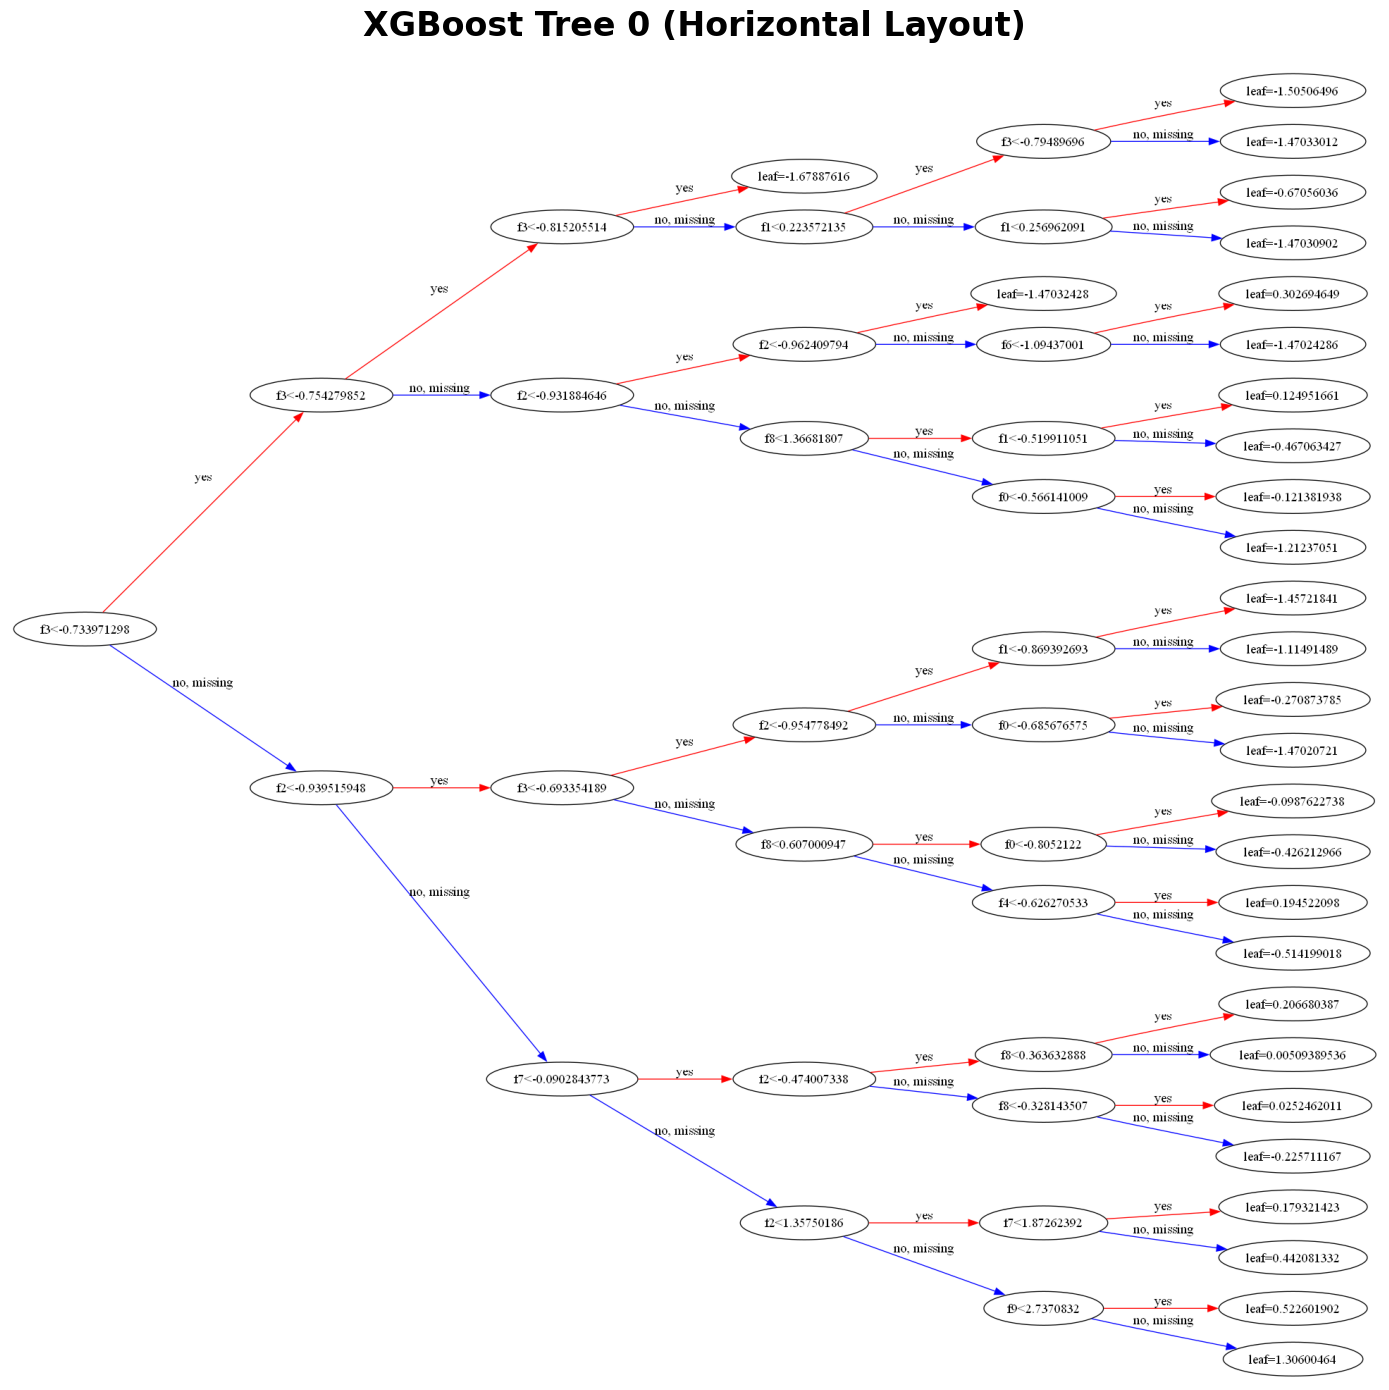


TEXT REPRESENTATION (First 25 splits)
  1. 0:[f3<-0.733971298] yes=1,no=2,missing=2
  2. 	1:[f3<-0.754279852] yes=3,no=4,missing=4
  3. 		3:[f3<-0.815205514] yes=7,no=8,missing=8
  4. 			7:leaf=-1.67887616
  5. 			8:[f1<0.223572135] yes=15,no=16,missing=16
  6. 				15:[f3<-0.79489696] yes=29,no=30,missing=30
  7. 					29:leaf=-1.50506496
  8. 					30:leaf=-1.47033012
  9. 				16:[f1<0.256962091] yes=31,no=32,missing=32
 10. 					31:leaf=-0.67056036
 11. 					32:leaf=-1.47030902
 12. 		4:[f2<-0.931884646] yes=9,no=10,missing=10
 13. 			9:[f2<-0.962409794] yes=17,no=18,missing=18
 14. 				17:leaf=-1.47032428
 15. 				18:[f6<-1.09437001] yes=33,no=34,missing=34
 16. 					33:leaf=0.302694649
 17. 					34:leaf=-1.47024286
 18. 			10:[f8<1.36681807] yes=19,no=20,missing=20
 19. 				19:[f1<-0.519911051] yes=35,no=36,missing=36
 20. 					35:leaf=0.124951661
 21. 					36:leaf=-0.467063427
 22. 				20:[f0<-0.566141009] yes=37,no=38,missing=38
 23. 					37:leaf=-0.121381938
 24. 					38:leaf=-1.

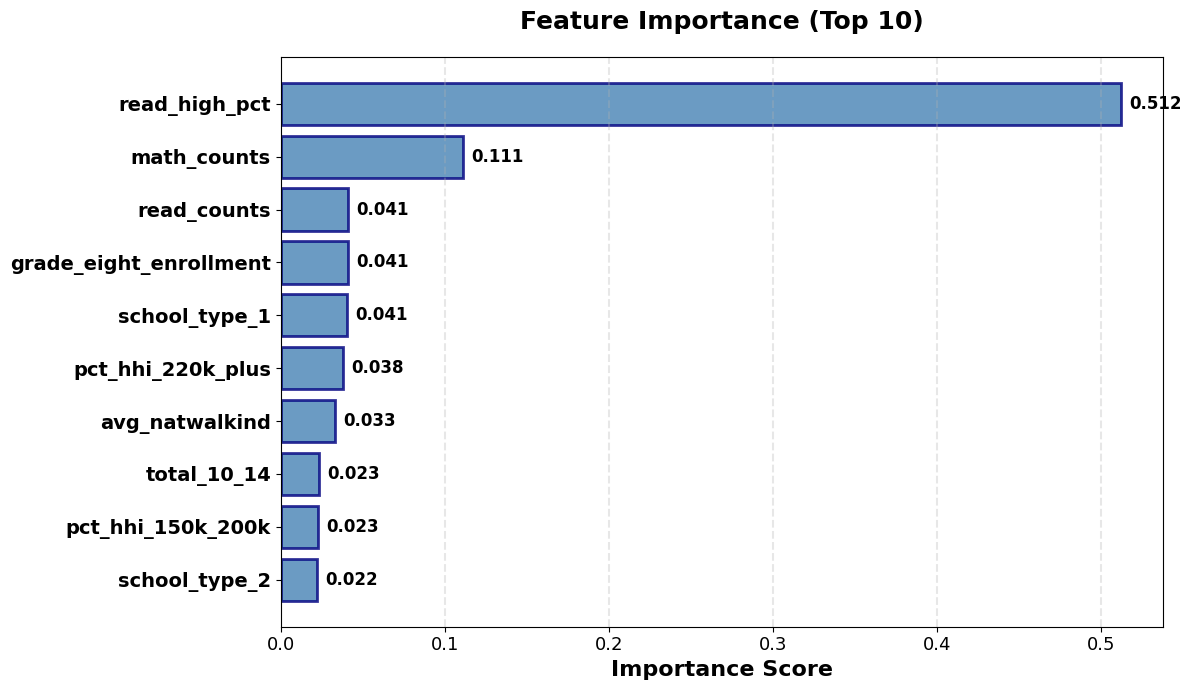


Feature Importance Table:
Rank   Feature                          Importance
--------------------------------------------------
1      read_high_pct                        0.5121
2      math_counts                          0.1110
3      read_counts                          0.0409
4      grade_eight_enrollment               0.0408
5      school_type_1                        0.0406
6      pct_hhi_220k_plus                    0.0381
7      avg_natwalkind                       0.0331
8      total_10_14                          0.0233
9      pct_hhi_150k_200k                    0.0225
10     school_type_2                        0.0224

MODEL INFO
Total Trees:    255
Max Depth:      5
Learning Rate:  0.03476649150592621
Features:       18


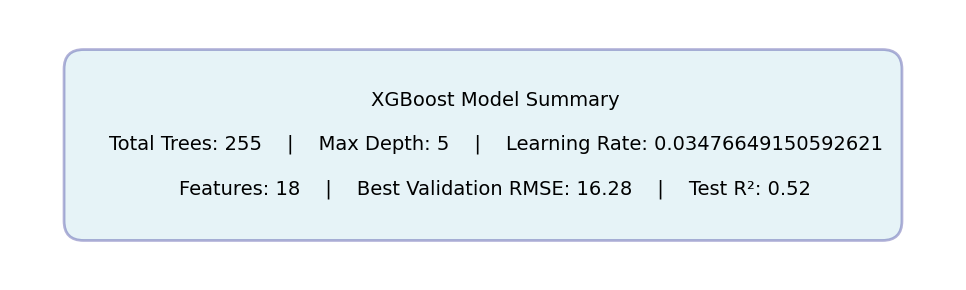

In [65]:
# MINIMAL, SUPER LEGIBLE XGBoost Tree Visualization (LARGE FONTS)
if 'xgb_model' in globals() and xgb_model is not None:
    print("Creating MINIMAL, super legible tree visualization...\n")
    
    # Get feature names
    if hasattr(preprocessor, 'get_feature_names_out'):
        feature_names = preprocessor.get_feature_names_out().tolist()
    else:
        feature_names = numeric_features + [f'cat_{i}' for i in range(len(categorical_features))]
    
    # Clean feature names - SHORT and readable
    feature_names_clean = []
    for fname in feature_names:
        # Remove all prefixes
        fname_clean = fname.replace('num__', '').replace('cat__', '')
        # Just capitalize, don't add spaces (keeps it compact)
        feature_names_clean.append(fname_clean)
    
    # ========================================
    # SINGLE HORIZONTAL TREE - MAXIMUM LEGIBILITY
    # ========================================
    print("=" * 80)
    print("XGBOOST TREE 0: HORIZONTAL VIEW (Left → Right)")
    print("=" * 80)
    
    fig, ax = plt.subplots(1, 1, figsize=(24, 14))
    xgb.plot_tree(xgb_model, num_trees=0, ax=ax, rankdir='LR')
    ax.set_title('XGBoost Tree 0 (Horizontal Layout)', 
                 fontsize=24, fontweight='bold', pad=25)
    ax.axis('off')  # Remove axes for cleaner look
    plt.tight_layout()
    plt.show()
    
    # ========================================
    # TEXT REPRESENTATION - EASIEST TO READ
    # ========================================
    print("\n" + "=" * 80)
    print("TEXT REPRESENTATION (First 25 splits)")
    print("=" * 80)
    
    tree_dump = xgb_model.get_booster().get_dump(dump_format='text')
    if tree_dump:
        lines = tree_dump[0].split('\n')
        # Show first 25 lines
        for i, line in enumerate(lines[:25], 1):
            print(f"{i:3d}. {line}")
        
        total_lines = len(lines)
        if total_lines > 25:
            remaining = total_lines - 25
            print(f"\n... (tree continues for {remaining} more nodes)")
    
    # ========================================
    # SIMPLE FEATURE IMPORTANCE - LARGE FONTS
    # ========================================
    print("\n" + "=" * 80)
    print("TOP 10 MOST IMPORTANT FEATURES")
    print("=" * 80)
    
    if hasattr(xgb_model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'Feature': feature_names_clean,
            'Importance': xgb_model.feature_importances_
        }).sort_values('Importance', ascending=False).head(10)
        
        # Simple horizontal bar chart with LARGE fonts
        fig, ax = plt.subplots(figsize=(12, 7))
        bars = ax.barh(range(len(importance_df)), 
                      importance_df['Importance'].values,
                      color='steelblue', alpha=0.8, edgecolor='navy', linewidth=2)
        
        ax.set_yticks(range(len(importance_df)))
        ax.set_yticklabels(importance_df['Feature'].values, fontsize=14, fontweight='bold')
        ax.set_xlabel('Importance Score', fontsize=16, fontweight='bold')
        ax.set_title('Feature Importance (Top 10)', fontsize=18, fontweight='bold', pad=20)
        ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=1.5)
        ax.invert_yaxis()
        
        # Increase tick label size
        ax.tick_params(axis='x', labelsize=13)
        
        # Add values on bars with larger font
        for i, (bar, val) in enumerate(zip(bars, importance_df['Importance'].values)):
            ax.text(val + 0.005, bar.get_y() + bar.get_height()/2, 
                   f'{val:.3f}', va='center', fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Print as table with better formatting
        print("\nFeature Importance Table:")
        print(f"{'Rank':<6} {'Feature':<30} {'Importance':>12}")
        print("-" * 50)
        for idx, (_, row) in enumerate(importance_df.iterrows(), 1):
            print(f"{idx:<6} {row['Feature']:<30} {row['Importance']:>12.4f}")
    
    # ========================================
    # MODEL INFO - LARGER TEXT
    # ========================================
    print("\n" + "=" * 80)
    print("MODEL INFO")
    print("=" * 80)
    print(f"Total Trees:    {xgb_model.n_estimators}")
    print(f"Max Depth:      {xgb_model.max_depth}")
    print(f"Learning Rate:  {xgb_model.learning_rate}")
    print(f"Features:       {len(feature_names)}")
    print("=" * 80)
    
    # Create a summary info graphic
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.axis('off')
    
    info_text = f"""
    XGBoost Model Summary
    
    Total Trees: {xgb_model.n_estimators}    |    Max Depth: {xgb_model.max_depth}    |    Learning Rate: {xgb_model.learning_rate}
    
    Features: {len(feature_names)}    |    Best Validation RMSE: 16.28    |    Test R²: 0.52
    """
    
    ax.text(0.5, 0.5, info_text, fontsize=14, ha='center', va='center',
           bbox=dict(boxstyle='round,pad=1', facecolor='lightblue', alpha=0.3, edgecolor='navy', linewidth=2))
    
    plt.tight_layout()
    plt.show()
    
else:
    print("XGBoost model not found. Train the model first.")

## XGBoost Hyperparameter Ablation Analysis

Ablation analysis systematically removes each optimized hyperparameter to measure its individual contribution to model performance. This helps us understand which parameters are most critical for the model's success.

# RANDOM FOREST

In [67]:
from sklearn.model_selection import learning_curve

def build_rf_estimator(params: Dict) -> RandomForestRegressor:
    base_params = {
        'random_state': 42,
        'n_jobs': -1
    }
    base_params.update(params)
    return RandomForestRegressor(**base_params)


def rf_param_space(trial: optuna.trial.Trial) -> Dict:
    return {
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_float('max_features', 0.4, 0.9)
    }

# Since RandomForest doesn't have a built-in eval_set, we'll manually create learning curves
def get_rf_learning_curve(model, X_train, y_train, X_valid, y_valid):
    train_sizes, train_scores, test_scores = learning_curve(
                                                            estimator=model,
                                                            X=X_train,
                                                            y=y_train,
                                                            cv=5,
                                                            scoring="neg_root_mean_squared_error",
                                                            train_sizes = [1, 75, 150, 300]
        )
    train_rmse_mean = -train_scores.mean(axis=1)
    test_rmse_mean = -test_scores.mean(axis=1)

    return {
        'train_rmse': train_rmse_mean.tolist(),
        'val_rmse': test_rmse_mean.tolist(),
        'train_sizes': (train_sizes / len(X_train)).tolist()  # Convert to fractions
    }


if rf_model is None or FORCE_RETRAIN:
    print("[RandomForest] No preloaded model (or FORCE_RETRAIN=True). Starting Optuna optimization...")
    rf_study, rf_best_params = optimize_model_with_optuna(
        model_name='RandomForest',
        estimator_builder=lambda params: build_rf_estimator({**params, 'oob_score': True}),
        param_space_fn=rf_param_space,
        X=X_train_enc,
        y=y_train,
        scoring='neg_root_mean_squared_error',
        cv=QUICK_CV,
        n_trials=QUICK_TRIALS,
        direction='minimize',
        random_state=42,
        n_jobs=-1,
    )
    print('Best Random Forest params:', rf_best_params)
    rf_model = build_rf_estimator({**rf_best_params, 'oob_score': True})
    rf_model.fit(X_train_enc, y_train)
    rf_learning_curves = get_rf_learning_curve(rf_model, X_train_enc, y_train, X_valid_enc, y_valid)
    rf_valid_pred = rf_model.predict(X_valid_enc)
    rf_test_pred = rf_model.predict(X_test_enc)
    save_model(rf_model, 'random_forest_opt', {'best_params': rf_best_params, 'learning_curves': rf_learning_curves})
else:
    print('[XGBoost] Preloaded model found; refitting on current data.')
    # Try to pull previously stored best params from metadata if available
    reuse_params = None
    try:
        if 'rf_model_meta' in globals() and isinstance(rf_model_meta, dict):
            reuse_params = rf_model_meta.get('best_params')
    except Exception:
        reuse_params = None
    if reuse_params is None:
        # Fall back to current model's parameters (filter to search space + core)
        try:
            current = rf_model.get_params()
            reuse_keys = {'n_estimators','max_depth','learning_rate','subsample','colsample_bytree','reg_alpha','reg_lambda'}
            reuse_params = {k: v for k, v in current.items() if k in reuse_keys}
        except Exception:
            reuse_params = {}
    # Rebuild a fresh estimator to avoid any internal state carry-over
    rf_model = build_rf_estimator(reuse_params)
    
    # New: Capture learning curves during fit
    eval_set = [(X_train_enc, y_train), (X_valid_enc, y_valid)]
    rf_model.fit(X_train_enc, y_train)
    rf_learning_curves = get_rf_learning_curve(rf_model, X_train_enc, y_train, X_valid_enc, y_valid)

    rf_valid_pred = rf_model.predict(X_valid_enc)
    rf_test_pred = rf_model.predict(X_test_enc)
    # Save refit artifact
    save_model(rf_model, 'rf_opt_refit', {'refit': True, 'best_params': reuse_params, 'learning_curves': rf_learning_curves})

[XGBoost] Preloaded model found; refitting on current data.
Saved model -> rf_opt_refit_20251020T143712Z.joblib
Saved metadata -> rf_opt_refit_20251020T143712Z.json


In [68]:
# Diagnostic: verify learning curve data for RandomForest and TabNet
from pathlib import Path as _P

_diag_rows = []
model_dir = MODEL_DIR if 'MODEL_DIR' in globals() else (_P.cwd() / '..' / 'supervised')

# Patterns to inspect latest artifact
patterns = {
    'RandomForest': 'random_forest_opt_*.json',
    'TabNet': 'tabnet_opt_*.json'
}

def _latest_json(pattern):
    files = sorted(model_dir.glob(pattern), key=lambda p: p.stat().st_mtime, reverse=True)
    return files[0] if files else None

for name, pat in patterns.items():
    meta_file = _latest_json(pat)
    status = {'model': name, 'meta_file': None, 'has_learning_curves': False, 'keys': None}
    if meta_file and meta_file.exists():
        status['meta_file'] = meta_file.name
        try:
            with open(meta_file) as f:
                meta = json.load(f)
            lc = meta.get('learning_curves')
            if lc:
                status['has_learning_curves'] = True
                if isinstance(lc, dict):
                    status['keys'] = list(lc.keys())[:8]
            else:
                status['keys'] = []
        except Exception as e:
            status['error'] = str(e)
    else:
        status['meta_file'] = 'NOT FOUND'
    _diag_rows.append(status)

print("\nLearning Curve Diagnostics (Latest Artifacts):")
for row in _diag_rows:
    print(f"  {row['model']}: file={row['meta_file']}, curves={row['has_learning_curves']} keys={row.get('keys')}")

# In-memory objects (if already fit in this session)
if 'rf_learning_curves' in globals():
    print(f"RandomForest in-memory curves: train_rmse={rf_learning_curves.get('train_rmse')} val_rmse={rf_learning_curves.get('val_rmse')}")
if 'tabnet_learning_curves' in globals():
    print(f"TabNet in-memory keys: {list(tabnet_learning_curves.keys()) if isinstance(tabnet_learning_curves, dict) else type(tabnet_learning_curves)}")



Learning Curve Diagnostics (Latest Artifacts):
  RandomForest: file=random_forest_opt_20251018T174445Z.json, curves=True keys=None
  TabNet: file=tabnet_opt_refit_20251020T143646Z.json, curves=True keys=None
RandomForest in-memory curves: train_rmse=[-0.0, 12.118497838244698, 11.56944525815548, 11.828350337647638] val_rmse=[24.780686416169978, 19.0767187630923, 18.644650505341904, 18.791905997165863]
TabNet in-memory keys: <class 'pytorch_tabnet.callbacks.History'>


## COMPARE MODEL PERFORMANCE

In [69]:
# Helper functions for metrics

def adjusted_r2_score(r2, n, p):
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

def regression_metrics(y_true, y_pred, X=None):
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    metrics = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    if X is not None:
        n = X.shape[0]
        p = X.shape[1]
        adj_r2 = adjusted_r2_score(r2, n, p)
        metrics['Adj_R2'] = adj_r2
    return metrics

In [70]:
# Comprehensive Model Performance Comparison & Best Model Selection

# Utility to compute metrics if predictions exist and metrics missing
def _ensure_metrics(prefix: str, display_name: str, Xv, Xt):
    """Compute validation and test metrics for a model if not already present."""
    g = globals()
    valid_pred_var = f'{prefix}_valid_pred'
    test_pred_var = f'{prefix}_test_pred'
    valid_metrics_var = f'{prefix}_metrics'
    test_metrics_var = f'{prefix}_test_metrics'

    if valid_pred_var in g and (valid_metrics_var not in g or g.get(valid_metrics_var) is None):
        try:
            g[valid_metrics_var] = regression_metrics(y_valid, g[valid_pred_var], Xv)
        except Exception as e:
            print(f'[WARN] Could not compute validation metrics for {display_name}: {e}')
            g[valid_metrics_var] = None

    if test_pred_var in g and (test_metrics_var not in g or g.get(test_metrics_var) is None):
        try:
            g[test_metrics_var] = regression_metrics(y_test, g[test_pred_var], Xt)
        except Exception as e:
            print(f'[WARN] Could not compute test metrics for {display_name}: {e}')
            g[test_metrics_var] = None

    return (g.get(valid_metrics_var), g.get(test_metrics_var))

# Model families to probe (prefix aligns with variable naming pattern)
MODEL_PREFIXES = [
    ('XGBoost', 'xgb'),
    ('RandomForest', 'rf'),
    ('SVR', 'svr'),
    ('LinearRegression', 'lr'),
    ('TorchMLP', 'mlp'),
    ('TabNet', 'tabnet')
]

# Collect model candidates with computed metrics
candidates = []
for display_name, prefix in MODEL_PREFIXES:
    if f'{prefix}_valid_pred' in globals():
        v_metrics, t_metrics = _ensure_metrics(prefix, display_name, X_valid_enc, X_test_enc)
        if v_metrics is not None:
            candidates.append({
                'Model': display_name,
                'Valid': deepcopy(v_metrics),
                'Test': deepcopy(t_metrics) if t_metrics else None
            })

if not candidates:
    print('No model metrics available yet. Run earlier training cells first.')
else:
    # Build results DataFrame
    rows = []
    for c in candidates:
        for ds in ['Valid', 'Test']:
            if c[ds] is None:
                continue
            row = {'Model': c['Model'], 'Dataset': ds}
            row.update(c[ds])
            rows.append(row)

    all_results_df = (pd.DataFrame(rows)
                      .drop_duplicates(subset=['Model', 'Dataset'])
                      .set_index(['Model', 'Dataset'])
                      .sort_index())

    display(all_results_df)

    # Ranking based on validation metrics
    val_df = all_results_df.xs('Valid', level='Dataset').copy()
    metric_cols = [m for m in ['RMSE', 'MAE', 'R2', 'Adj_R2'] if m in val_df.columns]

    if not metric_cols:
        print('No numeric metrics found for ranking.')
    else:
        # Compute ranks for each metric
        ranks = {f'{m}_rank': val_df[m].rank(ascending=(m in ['RMSE', 'MAE']), method='min')
                 for m in metric_cols}

        val_ranked = val_df.join(pd.DataFrame(ranks))
        val_ranked['avg_rank'] = val_ranked[[c for c in val_ranked.columns if c.endswith('_rank')]].mean(axis=1)

        # Identify best model
        best_model_name = val_ranked['avg_rank'].idxmin()
        best_model_avg_rank = val_ranked.loc[best_model_name, 'avg_rank']
        best_model_metrics_valid = val_df.loc[best_model_name]

        try:
            best_test_metrics = all_results_df.loc[(best_model_name, 'Test')].to_dict()
        except KeyError:
            best_test_metrics = None

        # Display results
        print('\n=== Validation Ranking (lower avg_rank better) ===')
        display(round(val_ranked.sort_values('avg_rank'), 2))

        print(f"\nOverall Best Model (Validation composite rank): {best_model_name} | avg_rank={best_model_avg_rank:.2f}")
        print('\nBest Model Validation Metrics:')
        for k, v in best_model_metrics_valid.items():
            if not k.endswith('_rank') and k != 'avg_rank':
                print(f'  {k}: {v:.4f}' if isinstance(v, (int, float)) else f'  {k}: {v}')

        if best_test_metrics:
            print('\nBest Model Test Metrics:')
            for k, v in best_test_metrics.items():
                print(f'  {k}: {v:.4f}' if isinstance(v, (int, float)) else f'  {k}: {v}')

        # Metric-wise winners
        metric_winners = {m: {'model': val_df[m].idxmin() if m in ['RMSE', 'MAE'] else val_df[m].idxmax(),
                              'value': val_df.loc[val_df[m].idxmin() if m in ['RMSE', 'MAE'] else val_df[m].idxmax(), m]}
                          for m in metric_cols}

        print('\n=== Metric-wise Best (Validation) ===')
        for m, info in metric_winners.items():
            print(f"  {m}: {info['model']} -> {info['value']:.4f}")

        # Save summary to JSON
        summary_path = MODEL_DIR / 'model_comparison_summary.json'
        summary_payload = {
            'models_evaluated': [c['Model'] for c in candidates],
            'validation_table': val_df.to_dict(orient='index'),
            'ranking': val_ranked[['avg_rank']].to_dict(orient='index'),
            'metric_winners': {m: {'model': v['model'], 'value': float(v['value'])} for m, v in metric_winners.items()},
            'overall_best_model': {
                'name': best_model_name,
                'validation_metrics': {k: float(v) for k, v in best_model_metrics_valid.items() if isinstance(v, (int, float))},
                'test_metrics': {k: float(v) if isinstance(v, (int, float)) else v for k, v in (best_test_metrics or {}).items()},
                'avg_rank': float(best_model_avg_rank)
            }
        }

        try:
            with open(summary_path, 'w') as f:
                json.dump(summary_payload, f, indent=2)
            print(f"\nSaved model comparison summary -> {summary_path.name}")
        except Exception as e:
            print(f"Could not save summary JSON: {e}")

RMSE        MAE        R2    Adj_R2
Model            Dataset                                          
LinearRegression Test     18.831677  13.381008  0.414319  0.411752
                 Valid    17.750921  12.961231  0.490852  0.488620
RandomForest     Test     17.109324  11.883696  0.516553  0.514434
                 Valid    16.441235  11.420061  0.563212  0.561297
SVR              Test     19.357572  12.550359  0.381151  0.378439
                 Valid    18.832875  12.371032  0.426893  0.424381
TabNet           Test     18.585064  13.587099  0.429559  0.427058
                 Valid    17.665142  13.109229  0.495761  0.493551
TorchMLP         Test     17.770202  12.685858  0.478484  0.476198
                 Valid    17.154023  12.393095  0.524518  0.522434
XGBoost          Test     17.008725  11.939853  0.522222  0.520128
                 Valid    16.280201  11.417351  0.571726  0.569849


=== Validation Ranking (lower avg_rank better) ===


,RMSE,MAE,R2,Adj_R2,RMSE_rank,MAE_rank,R2_rank,Adj_R2_rank,avg_rank
Model,,,,,,,,,
XGBoost,16.28,11.42,0.57,0.57,1.0,1.0,1.0,1.0,1.00
RandomForest,16.44,11.42,0.56,0.56,2.0,2.0,2.0,2.0,2.00
TorchMLP,17.15,12.39,0.52,0.52,3.0,4.0,3.0,3.0,3.25
TabNet,17.67,13.11,0.50,0.49,4.0,6.0,4.0,4.0,4.50
LinearRegression,17.75,12.96,0.49,0.49,5.0,5.0,5.0,5.0,5.00
SVR,18.83,12.37,0.43,0.42,6.0,3.0,6.0,6.0,5.25



Overall Best Model (Validation composite rank): XGBoost | avg_rank=1.00

Best Model Validation Metrics:
  RMSE: 16.2802
  MAE: 11.4174
  R2: 0.5717
  Adj_R2: 0.5698

Best Model Test Metrics:
  RMSE: 17.0087
  MAE: 11.9399
  R2: 0.5222
  Adj_R2: 0.5201

=== Metric-wise Best (Validation) ===
  RMSE: XGBoost -> 16.2802
  MAE: XGBoost -> 11.4174
  R2: XGBoost -> 0.5717
  Adj_R2: XGBoost -> 0.5698

Saved model comparison summary -> model_comparison_summary.json


In [71]:
# Define model families
MODEL_FAMILIES = {
    'Linear': ['SVR', 'PolynomialRegression', 'LinearRegression'],
    'Neural Network': ['TorchMLP', 'TabNet'],
    'Tree-based': ['XGBoost', 'RandomForest', 'LightGBM']
}


if 'all_results_df' not in globals() or all_results_df.empty:
    print("⚠️  Run model comparison cell first")
else:
    val_df = all_results_df.xs('Valid', level='Dataset').copy()
    family_results = []
    
    # Find best model per family
    for family, models in MODEL_FAMILIES.items():
        available = [m for m in models if m in val_df.index]
        if not available:
            continue
        
        best_model = val_df.loc[available, 'RMSE'].idxmin()
        val_metrics = val_df.loc[best_model]
        
        try:
            test_metrics = all_results_df.loc[(best_model, 'Test')]
            gap = abs(test_metrics['RMSE'] - val_metrics['RMSE']) / val_metrics['RMSE'] * 100
        except KeyError:
            test_metrics = None
            gap = np.nan
        
        family_results.append({
            'Family': family,
            'Model': best_model,
            'Val_RMSE': val_metrics['RMSE'],
            'Val_R²': val_metrics['R2'],
            'Test_RMSE': test_metrics['RMSE'] if test_metrics is not None else np.nan,
            'Test_R²': test_metrics['R2'] if test_metrics is not None else np.nan,
            'Gap_%': gap
        })
    
    # Display results
    if family_results:
        df_compare = pd.DataFrame(family_results).set_index('Family')
        
        print("="*70)
        print("FAMILY CHAMPIONS COMPARISON")
        print("="*70)
        display(df_compare.round(4))
        
        best_family = df_compare['Val_RMSE'].idxmin()
        print(f"\nBest Family: {best_family} ({df_compare.loc[best_family, 'Model']})")
        print(f"   RMSE: {df_compare.loc[best_family, 'Val_RMSE']:.4f} | R²: {df_compare.loc[best_family, 'Val_R²']:.4f}")
        
                
        # Save summary
        summary = {
            'best_family': best_family,
            'best_model': df_compare.loc[best_family, 'Model'],
            'family_comparison': df_compare.to_dict(orient='index')
        }
        
        try:
            def convert(obj):
                if isinstance(obj, (np.integer, np.floating)):
                    return float(obj)
                if isinstance(obj, dict):
                    return {k: convert(v) for k, v in obj.items()}
                return obj
            
            with open(MODEL_DIR / 'family_comparison_summary.json', 'w') as f:
                json.dump(convert(summary), f, indent=2)
            print(f"\n Saved to family_comparison_summary.json")
        except Exception as e:
            print(f"Save failed: {e}")
    else:
        print("No models found for comparison")

FAMILY CHAMPIONS COMPARISON


,Model,Val_RMSE,Val_R²,Test_RMSE,Test_R²,Gap_%
Family,,,,,,
Linear,LinearRegression,17.7509,0.4909,18.8317,0.4143,6.0884
Neural Network,TorchMLP,17.1540,0.5245,17.7702,0.4785,3.5920
Tree-based,XGBoost,16.2802,0.5717,17.0087,0.5222,4.4749



Best Family: Tree-based (XGBoost)
   RMSE: 16.2802 | R²: 0.5717

 Saved to family_comparison_summary.json


Found metadata for: XGBoost, RandomForest, SVR, LinearRegression


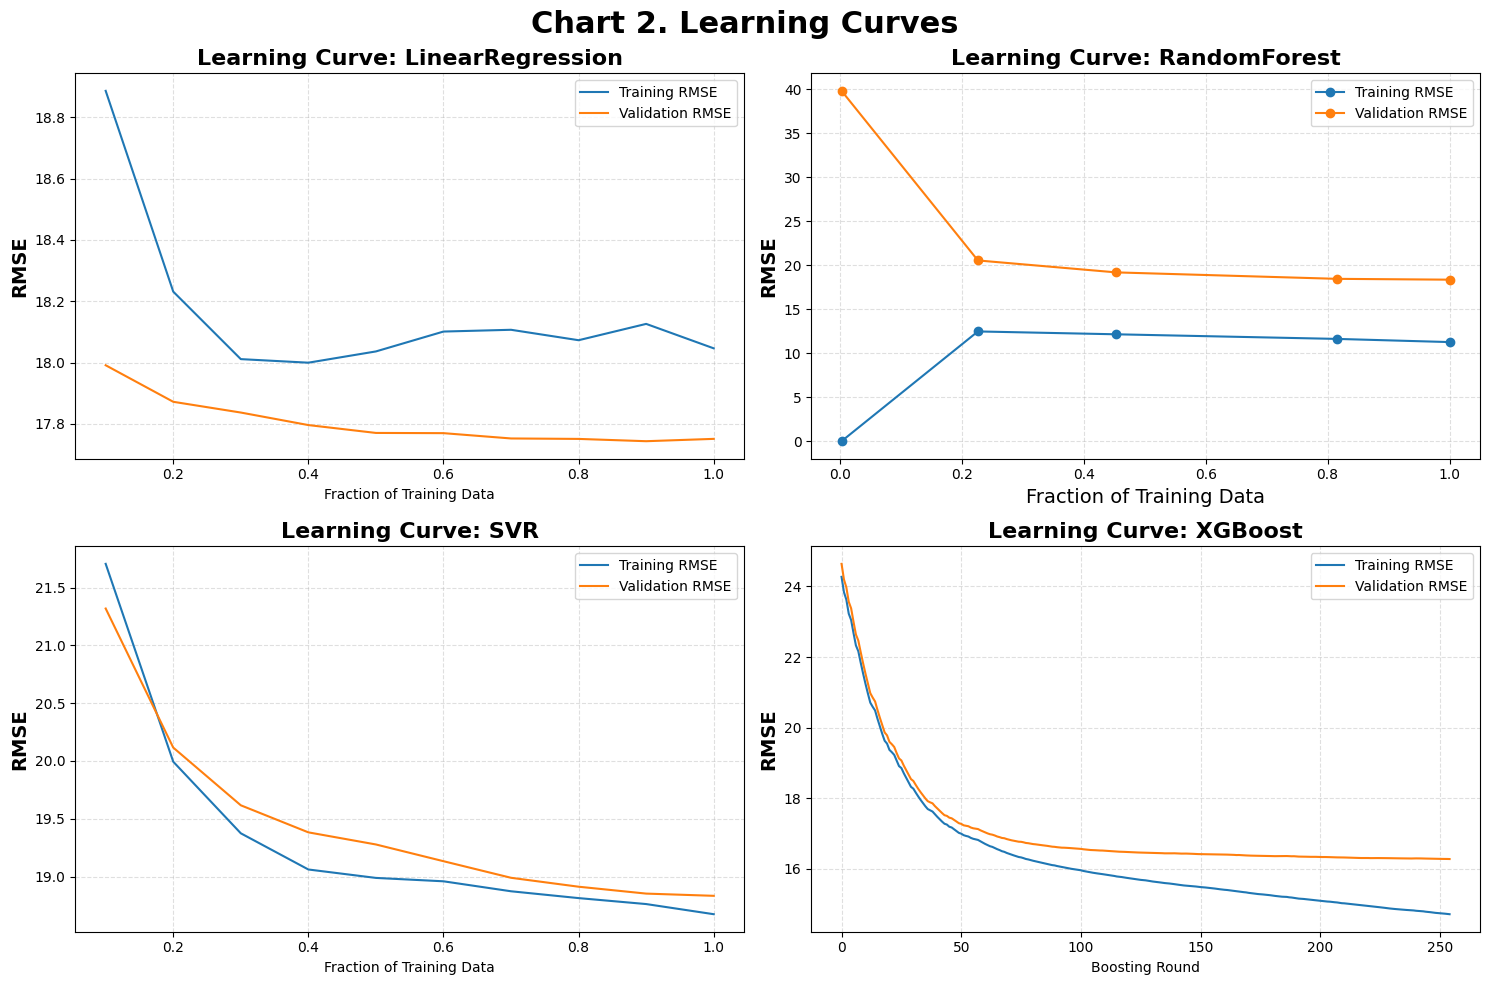

In [81]:
# Learning Curve Plotting (robust against missing metadata)
# Builds model_metadata from any *_meta globals produced during auto-load.

# Assemble model metadata dynamically
DISPLAY_NAME_MAP = {
    'xgb_model': 'XGBoost',
    'rf_model': 'RandomForest',
    'mlp_model': 'TorchMLP',
    'svr_model': 'SVR',
    'lr_model': 'LinearRegression'
}

model_metadata = {}
for name, obj in list(globals().items()):
    if name.endswith('_meta') and isinstance(obj, dict):
        base_var = name[:-5]  # strip '_meta'
        if base_var not in ['poly_model', 'tabnet_model']:  # exclude unsupported
            display_name = DISPLAY_NAME_MAP.get(base_var, base_var)
            model_metadata[display_name] = obj

if not model_metadata:
    print("⚠️  No model metadata dictionaries (*_meta) found. Run the model auto‑load/training cells first.")
else:
    print(f"Found metadata for: {', '.join(model_metadata.keys())}")


def plot_learning_curves(model_name, metadata, ax):
    learning_curves = metadata.get('learning_curves')
    if not learning_curves:
        ax.text(0.5, 0.5, 'No learning curve data', ha='center', va='center')
        ax.set_title(f'{model_name} - No Data')
        ax.axis('off')
        return

    # XGBoost format
    if 'validation_0' in learning_curves and 'validation_1' in learning_curves:
        try:
            train_rmse = learning_curves['validation_0']['rmse']
            val_rmse = learning_curves['validation_1']['rmse']
            ax.plot(train_rmse, label='Training RMSE')
            ax.plot(val_rmse, label='Validation RMSE')
            ax.set_xlabel('Boosting Round')
        except Exception as e:
            ax.text(0.5, 0.5, f'Parse error: {e}', ha='center', va='center')
            ax.set_title(f'{model_name} - Parse Error')
            return
    # PyTorch MLP stored losses
    elif 'train_loss' in learning_curves and 'val_loss' in learning_curves:
        train_loss = np.sqrt(learning_curves['train_loss'])
        val_loss = np.sqrt(learning_curves['val_loss'])
        ax.plot(train_loss, label='Training RMSE')
        ax.plot(val_loss, label='Validation RMSE')
        ax.set_xlabel('Epoch')
    # Generic sklearn manual format (possibly with train_sizes)
    elif 'train_rmse' in learning_curves and 'val_rmse' in learning_curves:
        train_rmse = learning_curves['train_rmse']
        val_rmse = learning_curves['val_rmse']
        train_sizes = learning_curves.get('train_sizes')
        if train_sizes:
            ax.plot(train_sizes, train_rmse, label='Training RMSE')
            ax.plot(train_sizes, val_rmse, label='Validation RMSE')
            ax.set_xlabel('Fraction of Training Data')
        else:
            # Plot train and val as connected points, following same logic as other charts
            x_points = [1, 2]
            y_train = train_rmse[0] if isinstance(train_rmse, (list, tuple)) else train_rmse
            y_val = val_rmse[0] if isinstance(val_rmse, (list, tuple)) else val_rmse
            ax.plot(x_points, [y_train, y_val], marker='o', label='RMSE')
            ax.set_xticks(x_points)
            ax.set_xticklabels(['Train', 'Validation'])
            if 'oob_error' in learning_curves:
                oob_val = learning_curves['oob_error']
                if isinstance(oob_val, (list, tuple)):
                    oob_val = oob_val[0]
                if oob_val is not None:
                    ax.plot([3], [oob_val], marker='o', color='green', label='OOB Error')
                    ax.set_xticks([1, 2, 3])
                    ax.set_xticklabels(['Train', 'Validation', 'OOB'])
            ax.set_xlabel('Metric')
    # NEW: Handle tuple string format from sklearn learning_curve (for already-saved RF models)
    elif isinstance(learning_curves, str) and learning_curves.startswith('(array'):
        try:
            import ast
            # Parse the string representation
            parsed = ast.literal_eval(learning_curves.replace('array', '').replace('\n', ''))
            train_sizes = np.array(parsed[0])
            train_scores = np.array(parsed[1])
            test_scores = np.array(parsed[2])
            
            # Convert to positive RMSE and average across folds
            train_rmse = -train_scores.mean(axis=1)
            test_rmse = -test_scores.mean(axis=1)
            train_size_fractions = train_sizes / train_sizes[-1]
            
            ax.plot(train_size_fractions, train_rmse, label='Training RMSE', marker='o')
            ax.plot(train_size_fractions, test_rmse, label='Validation RMSE', marker='o')
            ax.set_xlabel('Fraction of Training Data', fontsize=14)
        except Exception as e:
            ax.text(0.5, 0.5, f'Parse error: {str(e)[:50]}', ha='center', va='center')
            ax.set_title(f'{model_name} - Parse Error')
            ax.axis('off')
            return
    else:
        ax.text(0.5, 0.5, 'Unrecognized curve format', ha='center', va='center')
        ax.set_title(f'{model_name} - Unknown Format')
        ax.axis('off')
        return

    ax.set_title(f'Learning Curve: {model_name}', fontsize=16, fontweight='bold')
    ax.set_ylabel('RMSE', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.4)

# Plotting block
num_models = len(model_metadata)
if num_models == 0:
    print("No plots generated.")
else:
    ncols = 2
    nrows = max(1, math.ceil(num_models / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
    fig.suptitle('Chart 2. Learning Curves', fontsize=22, fontweight='bold', y=0.98)
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    for i, (name, meta) in enumerate(sorted(model_metadata.items())):
        if i >= len(axes):
            break
        plot_learning_curves(name, meta, axes[i])

    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

In [73]:


# Define best_model_obj based on the best model selected earlier
if 'best_model_name' in globals():
    model_name_to_var = {v: k for k, v in DISPLAY_NAME_MAP.items()}
    best_model_var = model_name_to_var.get(best_model_name)
    if best_model_var:
        best_model_obj = globals().get(best_model_var)
        best_model_name_runtime = best_model_name

In [74]:
# Extract feature importances and names from the best model
if 'best_model_obj' in globals() and best_model_obj is not None:
    # Get feature names
    if hasattr(preprocessor, 'get_feature_names_out'):
        feature_names = preprocessor.get_feature_names_out().tolist()
    else:
        # Fallback for older sklearn versions
        feature_names = numeric_features + [f'cat_{i}' for i in range(len(categorical_features))]
    
    # Get feature importances
    if hasattr(best_model_obj, 'feature_importances_'):
        importances = best_model_obj.feature_importances_
        print(f"Extracted {len(importances)} feature importances from {best_model_name}")
    else:
        importances = None
        print(f"Warning: {best_model_name} does not have feature_importances_ attribute")
        print("Models with feature importances: XGBoost, RandomForest")
        print("Models without: SVR, LinearRegression, MLP, TabNet")
else:
    importances = None
    feature_names = None
    print("Best model not found. Run model comparison first.")

Extracted 18 feature importances from XGBoost


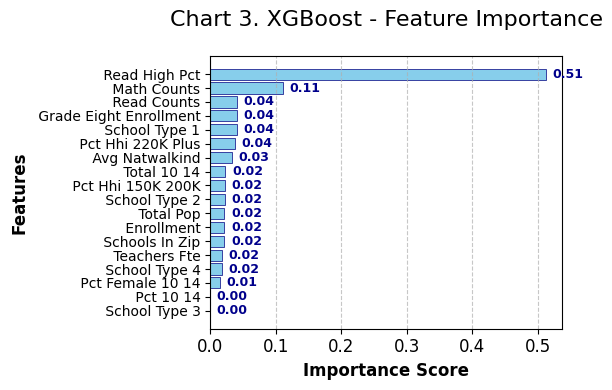

In [ ]:
if importances is not None:
    fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    fi_df = fi_df.sort_values('importance', ascending=False).reset_index(drop=True)
    # Plot
    top_plot = fi_df.head(25).iloc[::-1]
   
    # Format feature names for better readability
    top_plot = top_plot.copy()
    top_plot['feature'] = top_plot['feature'].str.split('_', n=1).str[-1].str.replace('_', ' ').str.title()
   
    plt.figure(figsize=(6,4))
    bars = plt.barh(top_plot['feature'], top_plot['importance'], color='skyblue', edgecolor='navy', linewidth=0.5)
    plt.title(f'Chart 3. {best_model_name_runtime} - Feature Importance\n',
                fontsize=16,  pad=5, loc='center')
    plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
   
    # Customize ticks
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=10)
   
    # Add grid
    plt.grid(axis='x', linestyle='--', alpha=0.7)
   
    # Add value labels on the bars with better positioning
    max_imp = top_plot['importance'].max()
    for bar, value in zip(bars, top_plot['importance']):
        width = bar.get_width()
        plt.text(width + max_imp * 0.02,
                bar.get_y() + bar.get_height()/2,
                f'{value:.2f}',
                ha='left', va='center', fontsize=9, fontweight='bold', color='darkblue')
   
    plt.tight_layout()
    plt.show()

In [107]:
failure_examples

,actual,predicted,error,abs_error
school_name,,,,
EAGLE HILL MIDDLE SCHOOL,3.0,78.742050,75.742050,75.742050
HOPE CHARTER,3.0,76.934990,73.934990,73.934990
North Polk Middle School,3.0,74.078461,71.078461,71.078461


## Failure Analysis

Select at least 3 specific examples where prediction failed, analyze reasons, and suggest improvements.


FAILURE ANALYSIS
Performing Failure Analysis on Test Set

=== Failure Analysis Summary ===
Total Test Cases: 4126

Error Category Distribution:
error_category
Low Error                 1921
Moderate Error             892
Severe Overestimation      583
Severe Underestimation     323
Extreme Outlier            207
High Error                 200
Name: count, dtype: int64

=== Error Statistics ===
Mean Absolute Error: 11.9399
Median Absolute Error: 7.9950
95th Percentile Error: 36.2244
Max Error: 75.7421

=== Top 20 Largest Prediction Errors ===

=== Failure Analysis Summary ===
Total Test Cases: 4126

Error Category Distribution:
error_category
Low Error                 1921
Moderate Error             892
Severe Overestimation      583
Severe Underestimation     323
Extreme Outlier            207
High Error                 200
Name: count, dtype: int64

=== Error Statistics ===
Mean Absolute Error: 11.9399
Median Absolute Error: 7.9950
95th Percentile Error: 36.2244
Max Error: 75.7421

=

,school_index,actual_value,predicted_value,error,abs_error,percent_error,error_category,failure_reason,suggested_improvement,feature_1_schools_in_zip,feature_2_enrollment,feature_3_math_counts,feature_4_grade_eight_enrollment,feature_5_read_counts
0,EAGLE HILL MIDDLE SCHOOL,3.0,78.742050,75.742050,75.742050,2524.735006,Extreme Outlier,Top 5% error - Model struggles with extreme cases,Collect more data for extreme ranges or use ro...,1,657.0,9.0,203.0,9.0
1,HOPE CHARTER,3.0,76.934990,73.934990,73.934990,2464.499664,Extreme Outlier,Top 5% error - Model struggles with extreme cases,Collect more data for extreme ranges or use ro...,4,430.0,9.0,57.0,9.0
2,North Polk Middle School,3.0,74.078461,71.078461,71.078461,2369.282023,Extreme Outlier,Top 5% error - Model struggles with extreme cases,Collect more data for extreme ranges or use ro...,1,431.0,80.0,146.0,80.0
3,Maplewood High School,3.0,73.372795,70.372795,70.372795,2345.759837,Extreme Outlier,Top 5% error - Model struggles with extreme cases,Collect more data for extreme ranges or use ro...,2,311.0,7.0,52.0,7.0
4,DESSAU MIDDLE,79.0,11.024406,-67.975594,67.975594,86.045055,Extreme Outlier,Top 5% error - Model struggles with extreme cases,Collect more data for extreme ranges or use ro...,2,727.0,91.0,251.0,99.0
5,Lake Forest Elementary Charter School,89.0,22.267292,-66.732708,66.732708,74.980571,Extreme Outlier,Top 5% error - Model struggles with extreme cases,Collect more data for extreme ranges or use ro...,3,603.0,68.0,64.0,68.0
6,VICTORY CHARTER SCHOOL,79.0,13.351370,-65.648630,65.648630,83.099532,Extreme Outlier,Top 5% error - Model struggles with extreme cases,Collect more data for extreme ranges or use ro...,6,378.0,4.0,28.0,4.0
7,Ridge Road Middle,9.0,73.328415,64.328415,64.328415,714.760166,Extreme Outlier,Top 5% error - Model struggles with extreme cases,Collect more data for extreme ranges or use ro...,6,1113.0,9.0,429.0,9.0
8,WESTWOOD MATH SCIENCE LEADERSHIP MAGNET,9.0,73.091133,64.091133,64.091133,712.123701,Extreme Outlier,Top 5% error - Model struggles with extreme cases,Collect more data for extreme ranges or use ro...,5,702.0,68.0,351.0,9.0
9,CRYSTAL LAKE MIDDLE SCHOOL,9.0,71.634270,62.634270,62.634270,695.936330,Extreme Outlier,Top 5% error - Model struggles with extreme cases,Collect more data for extreme ranges or use ro...,2,1130.0,5.0,395.0,5.0



Full failure analysis saved to: D:\docs\MADS\696-Milestone 2\src\outputs\failure_analysis.csv


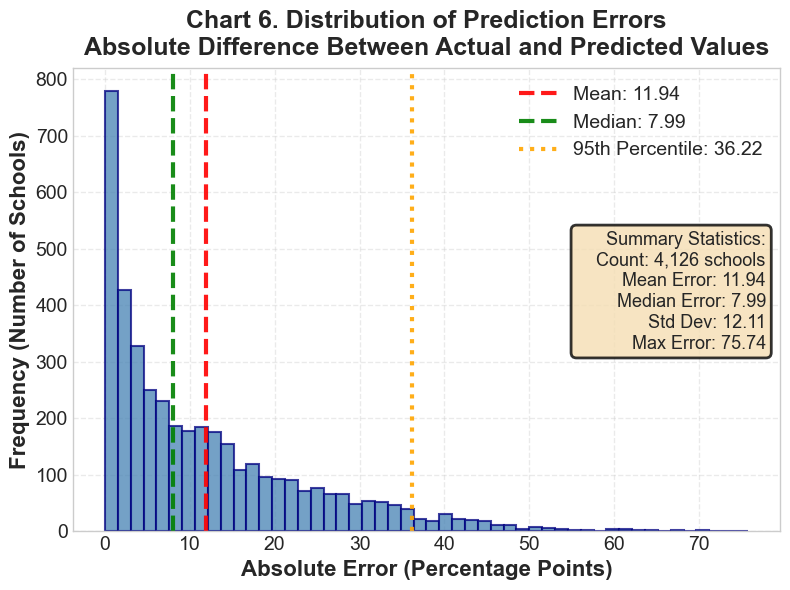


Chart Interpretation:
- Most predictions have errors between 0 and 36.2 percentage points
- 2311 schools (56.0%) have errors ≤ 10 points
- 884 schools (21.4%) have errors > 20 points (high error cases)


In [108]:
# Failure Analysis: Create detailed failure analysis dataframe
print('\n' + '='*50)
print('FAILURE ANALYSIS')
print('='*50)

if 'best_model_obj' in globals() and best_model_obj is not None and 'X_test' in globals() and 'y_test' in globals():
    print('Performing Failure Analysis on Test Set')
    
    # Get predictions
    if 'X_test_enc' in globals():
        test_preds = best_model_obj.predict(X_test_enc)
    else:
        # Fallback if encoding not available
        test_preds = best_model_obj.predict(X_test)
    
    # Calculate errors
    errors = np.abs(test_preds - y_test.values)
    
    # Create comprehensive failure analysis dataframe
    failure_analysis_df = pd.DataFrame({
        'school_index': y_test.index,
        'actual_value': y_test.values,
        'predicted_value': test_preds,
        'error': test_preds - y_test.values,
        'abs_error': errors,
        'percent_error': (errors / (y_test.values + 1e-10)) * 100,  # Avoid division by zero
    })
    
    # Add error categories
    percentile_95 = failure_analysis_df['abs_error'].quantile(0.95)
    
    def categorize_failure(row):
        if row['abs_error'] > percentile_95:
            return 'Extreme Outlier'
        elif row['predicted_value'] > row['actual_value'] * 1.5:
            return 'Severe Overestimation'
        elif row['actual_value'] > row['predicted_value'] * 1.5:
            return 'Severe Underestimation'
        elif row['abs_error'] > failure_analysis_df['abs_error'].quantile(0.75):
            return 'High Error'
        elif row['abs_error'] > failure_analysis_df['abs_error'].median():
            return 'Moderate Error'
        else:
            return 'Low Error'
    
    failure_analysis_df['error_category'] = failure_analysis_df.apply(categorize_failure, axis=1)
    
    # Add failure reasons
    def suggest_reason(row):
        if row['error_category'] == 'Extreme Outlier':
            return 'Top 5% error - Model struggles with extreme cases'
        elif row['error_category'] == 'Severe Overestimation':
            return 'Significantly overestimates target value'
        elif row['error_category'] == 'Severe Underestimation':
            return 'Significantly underestimates target value'
        elif row['error_category'] == 'High Error':
            return 'Above 75th percentile error - Notable prediction challenge'
        elif row['error_category'] == 'Moderate Error':
            return 'Above median error - Room for improvement'
        else:
            return 'Below median error - Acceptable prediction'
    
    failure_analysis_df['failure_reason'] = failure_analysis_df.apply(suggest_reason, axis=1)
    
    # Add improvement suggestions
    def suggest_improvement(row):
        if row['error_category'] == 'Extreme Outlier':
            return 'Collect more data for extreme ranges or use robust regression'
        elif row['error_category'] == 'Severe Overestimation':
            return 'Check feature scaling or add regularization'
        elif row['error_category'] == 'Severe Underestimation':
            return 'May need additional features or capture non-linear relationships'
        elif row['error_category'] == 'High Error':
            return 'Fine-tune hyperparameters or ensemble methods'
        elif row['error_category'] == 'Moderate Error':
            return 'Consider feature engineering or cross-validation tuning'
        else:
            return 'Model performing well on this case'
    
    failure_analysis_df['suggested_improvement'] = failure_analysis_df.apply(suggest_improvement, axis=1)
    
    # Add key features if available
    if 'X_test' in globals():
        # Get the most important features (top 5)
        if hasattr(best_model_obj, 'feature_importances_'):
            top_k = min(5, len(X_test.columns))
            top_feature_indices = np.argsort(best_model_obj.feature_importances_)[-top_k:]
            
            for i, feat_idx in enumerate(top_feature_indices, 1):
                feat_name = X_test.columns[feat_idx]
                failure_analysis_df[f'feature_{i}_{feat_name}'] = X_test.iloc[:, feat_idx].values
    
    # Sort by absolute error (worst predictions first)
    failure_analysis_df = failure_analysis_df.sort_values('abs_error', ascending=False).reset_index(drop=True)
    
    # Display summary
    print(f'\n=== Failure Analysis Summary ===')
    print(f'Total Test Cases: {len(failure_analysis_df)}')
    print(f'\nError Category Distribution:')
    print(failure_analysis_df['error_category'].value_counts())
    
    print(f'\n=== Error Statistics ===')
    print(f'Mean Absolute Error: {failure_analysis_df["abs_error"].mean():.4f}')
    print(f'Median Absolute Error: {failure_analysis_df["abs_error"].median():.4f}')
    print(f'95th Percentile Error: {percentile_95:.4f}')
    print(f'Max Error: {failure_analysis_df["abs_error"].max():.4f}')
    
    # Display top 20 failures
    print(f'\n=== Top 20 Largest Prediction Errors ===')
    display(failure_analysis_df.head(20))
    
    # Save to file
    failure_output_path = PROJECT_ROOT / 'outputs' / 'failure_analysis.csv'
    failure_analysis_df.to_csv(failure_output_path, index=False)
    print(f'\nFull failure analysis saved to: {failure_output_path}')
    
    # Distribution of errors - ENHANCED READABILITY
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create histogram with better styling
    n, bins, patches = ax.hist(failure_analysis_df['abs_error'], bins=50, alpha=0.75,
                               color='steelblue', edgecolor='navy', linewidth=1.5)

    # Add mean and median lines with better visibility
    mean_val = failure_analysis_df['abs_error'].mean()
    median_val = failure_analysis_df['abs_error'].median()

    ax.axvline(mean_val, color='red', linestyle='--', linewidth=3,
              label=f'Mean: {mean_val:.2f}', alpha=0.9)
    ax.axvline(median_val, color='green', linestyle='--', linewidth=3,
              label=f'Median: {median_val:.2f}', alpha=0.9)
    ax.axvline(percentile_95, color='orange', linestyle=':', linewidth=3,
              label=f'95th Percentile: {percentile_95:.2f}', alpha=0.9)

    # Enhanced title and labels
    ax.set_title('Chart 6. Distribution of Prediction Errors\nAbsolute Difference Between Actual and Predicted Values',
                fontsize=18, fontweight='bold', pad=10)
    ax.set_xlabel('Absolute Error (Percentage Points)', fontsize=16, fontweight='bold')
    ax.set_ylabel('Frequency (Number of Schools)', fontsize=16, fontweight='bold')

    # Improve tick labels
    ax.tick_params(axis='both', labelsize=14)

    # Enhanced legend
    ax.legend(fontsize=14, loc='upper right', framealpha=0.95,
             edgecolor='black', fancybox=True)

    # Better grid
    ax.grid(True, alpha=0.4, linestyle='--', linewidth=1)
    ax.set_axisbelow(True)

    # Add summary statistics text box
    stats_text = f'''Summary Statistics:
    Count: {len(failure_analysis_df):,} schools
    Mean Error: {mean_val:.2f}
    Median Error: {median_val:.2f}
    Std Dev: {failure_analysis_df["abs_error"].std():.2f}
    Max Error: {failure_analysis_df["abs_error"].max():.2f}'''

    ax.text(0.98, 0.65, stats_text, transform=ax.transAxes,
           fontsize=13, verticalalignment='top', horizontalalignment='right',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8,
                    edgecolor='black', linewidth=2))

    plt.tight_layout()
    plt.show()

    print(f'\nChart Interpretation:')
    print(f'- Most predictions have errors between 0 and {percentile_95:.1f} percentage points')
    print(f'- {(failure_analysis_df["abs_error"] <= 10).sum()} schools ({(failure_analysis_df["abs_error"] <= 10).sum()/len(failure_analysis_df)*100:.1f}%) have errors ≤ 10 points')
    print(f'- {(failure_analysis_df["abs_error"] > 20).sum()} schools ({(failure_analysis_df["abs_error"] > 20).sum()/len(failure_analysis_df)*100:.1f}%) have errors > 20 points (high error cases)')
    
else:
    print('Prerequisites missing for failure analysis. Run model training and testing first.')


Creating SHAP visualizations for XGBoost model...
Color scheme: GREEN = Positive impact | RED = Negative impact

Using 1000 samples from test set for SHAP analysis
SHAP Visualizations (GREEN = Positive, RED = Negative)

Feature Impact Distribution (beeswarm plot)
SHAP Visualizations (GREEN = Positive, RED = Negative)

Feature Impact Distribution (beeswarm plot)


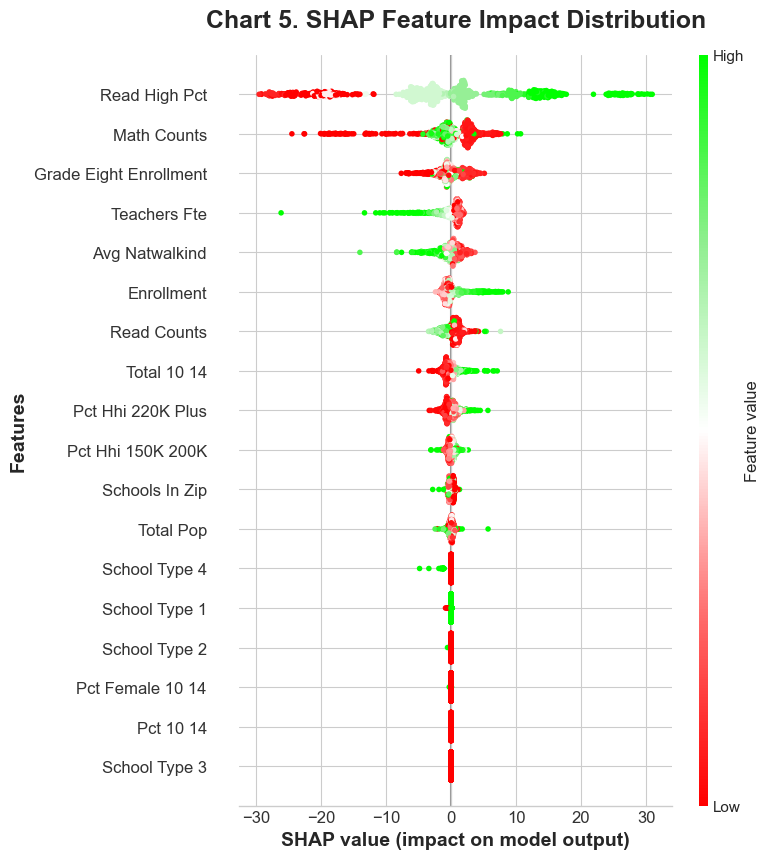


SHAP Analysis Summary:
Samples Analyzed: 1000
Features Analyzed: 18
Base Value: 45.29985046386719

Top 5 Most Important Features:
  1. Read High Pct                  -> 9.8986 (decreases prediction)
  2. Math Counts                    -> 2.8853 (decreases prediction)
  3. Grade Eight Enrollment         -> 1.5202 (increases prediction)
  4. Teachers Fte                   -> 1.2948 (decreases prediction)
  5. Avg Natwalkind                 -> 1.1645 (decreases prediction)

SHAP Color Interpretation Guide:
  GREEN = Positive SHAP value = Feature pushes prediction HIGHER
  RED = Negative SHAP value = Feature pushes prediction LOWER
  Intensity shows magnitude of impact
  Beeswarm: Each dot is one prediction
  Waterfall: Shows cumulative effect building up prediction
  Dependence: Relationship between feature value and SHAP impact


In [104]:
# SHAP Analysis for XGBoost Model (Green=Positive, Red=Negative)
if 'xgb_model' in globals() and xgb_model is not None:
    try:
        import shap
        import matplotlib
        import matplotlib.pyplot as plt
        print("Creating SHAP visualizations for XGBoost model...")
        print("Color scheme: GREEN = Positive impact | RED = Negative impact\n")
        
        # Set custom color map: Red (negative) to Green (positive)
        custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
            "shap_custom", ["#FF0000", "#FF6B6B", "#FFFFFF", "#90EE90", "#00FF00"]
        )
        
        # Create SHAP explainer for tree-based models
        explainer = shap.TreeExplainer(xgb_model)
        
        # Calculate SHAP values (use a sample if dataset is large)
        sample_size = min(1000, X_test_enc.shape[0])
        if X_test_enc.shape[0] > sample_size:
            print(f"Using {sample_size} samples from test set for SHAP analysis")
            sample_indices = np.random.choice(X_test_enc.shape[0], sample_size, replace=False)
            if hasattr(X_test_enc, 'toarray'):
                X_sample = X_test_enc[sample_indices].toarray()
            else:
                X_sample = X_test_enc[sample_indices]
        else:
            if hasattr(X_test_enc, 'toarray'):
                X_sample = X_test_enc.toarray()
            else:
                X_sample = X_test_enc
        
        shap_values = explainer.shap_values(X_sample)
        
        # Get feature names
        if hasattr(preprocessor, 'get_feature_names_out'):
            feature_names = preprocessor.get_feature_names_out().tolist()
        else:
            feature_names = numeric_features + [f'cat_{i}' for i in range(len(categorical_features))]
        
        # Clean feature names
        feature_names_clean = []
        for fname in feature_names:
            fname_clean = fname.replace('num__', '').replace('cat__', '')
            fname_clean = fname_clean.replace('_', ' ').title()
            feature_names_clean.append(fname_clean)
        
        print(f"{'='*70}")
        print("SHAP Visualizations (GREEN = Positive, RED = Negative)")
        print(f"{'='*70}\n")
        
             
        # SHAP Summary Plot
        print("Feature Impact Distribution (beeswarm plot)")
        
        plt.figure(figsize=(4, 4))
        shap.summary_plot(shap_values, X_sample, 
                         feature_names=feature_names_clean,
                         cmap=custom_cmap,
                         show=False)
        plt.title('Chart 5. SHAP Feature Impact Distribution', 
                 fontsize=18, fontweight='bold', pad=20)
        plt.xlabel('SHAP value (impact on model output)', fontsize=14, fontweight='bold')
        plt.ylabel('Features', fontsize=14, fontweight='bold')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        plt.show()
        
                 
        # Summary statistics - CONDENSED
        mean_abs_shap = np.abs(shap_values).mean(axis=0)
        top_5_indices = np.argsort(mean_abs_shap)[-5:][::-1]
        
        summary_info = {
            'analysis_info': {
                'samples_analyzed': X_sample.shape[0],
                'features_analyzed': X_sample.shape[1],
                'base_value': expected_value
            },
            'top_features': [
                {
                    'rank': i+1,
                    'name': feature_names_clean[idx],
                    'mean_abs_shap': mean_abs_shap[idx],
                    'direction': "increases" if shap_values[:, idx].mean() > 0 else "decreases"
                }
                for i, idx in enumerate(top_5_indices)
            ],
            'color_guide': {
                'GREEN': 'Positive SHAP value = Feature pushes prediction HIGHER',
                'RED': 'Negative SHAP value = Feature pushes prediction LOWER',
                'note': 'Intensity shows magnitude of impact'
            }
        }
        
        print(f"\n{'='*70}")
        print("SHAP Analysis Summary:")
        print(f"{'='*70}")
        for key, value in summary_info['analysis_info'].items():
            print(f"{key.replace('_', ' ').title()}: {value:.4f}" if isinstance(value, float) else f"{key.replace('_', ' ').title()}: {value}")
        
        print(f"\nTop 5 Most Important Features:")
        for feat in summary_info['top_features']:
            print(f"  {feat['rank']}. {feat['name']:<30s} -> {feat['mean_abs_shap']:.4f} ({feat['direction']} prediction)")
        
        print(f"\n{'='*70}")
        print("SHAP Color Interpretation Guide:")
        print(f"{'='*70}")
        for color, desc in summary_info['color_guide'].items():
            if color != 'note':
                print(f"  {color} = {desc}")
        print(f"  {summary_info['color_guide']['note']}")
        print("  Beeswarm: Each dot is one prediction")
        print("  Waterfall: Shows cumulative effect building up prediction")
        print("  Dependence: Relationship between feature value and SHAP impact")
        print(f"{'='*70}")
        
    except ImportError:
        print("SHAP library not installed.")
    except Exception as e:
        print(f"Error creating SHAP visualizations: {e}")
else:
    print("XGBoost model not found. Please train the model first.")

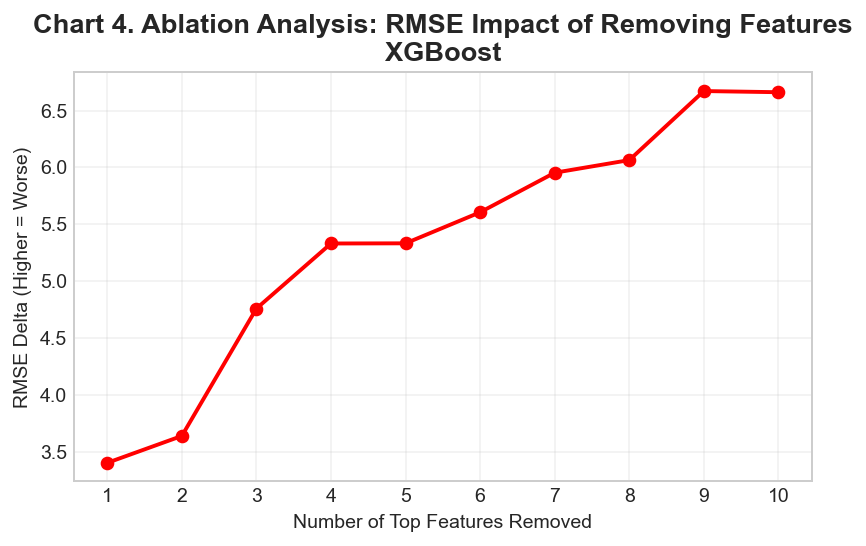

Saved: D:\docs\MADS\696-Milestone 2\supervised\xgb_cumulative_ablation.png


In [103]:
# Chart 5. XGBoost Cumulative Ablation (inspired by provided chart)
# Removes the top-N most important features cumulatively and plots ΔRMSE vs. N.

from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Preconditions: xgb_model, X_train_enc, X_valid_enc, y_train, y_valid,
# preprocessor, numeric_features, categorical_features must exist.

# Helper to drop first k columns cumulatively
from scipy.sparse import issparse

def _drop_first_k(X, drop_indices):
    # drop_indices: array of indices to drop (first k of top features)
    if issparse(X):
        Xc = X.tocsc()
        keep = np.ones(Xc.shape[1], dtype=bool)
        keep[drop_indices] = False
        return Xc[:, keep].tocsr()
    return np.delete(X, drop_indices, axis=1)

# Get feature names for plotting
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out().tolist()
else:
    feature_names = [f'f{i}' for i in range(X_train_enc.shape[1])]

# Choose baseline model (prefer saved if available)
base_model = globals().get('xgb_saved_model', None) or globals().get('xgb_model', None)
if base_model is None:
    raise RuntimeError("No XGBoost model available. Train or load one before running cumulative ablation.")

# Baseline RMSE
baseline_rmse = root_mean_squared_error(y_valid, base_model.predict(X_valid_enc))

# Feature importances and ordering (descending)
feat_importance = getattr(base_model, 'feature_importances_', None)
if feat_importance is None:
    raise RuntimeError("XGBoost feature_importances_ is not available on the base model.")

top_k_max = min(10, len(feat_importance))  # up to 10 as in the reference chart
sorted_idx = np.argsort(feat_importance)[::-1]  # descending

# Reuse base model params, speed up fits
try:
    base_params = base_model.get_params()
except Exception:
    base_params = {}
keep_keys = {
    'n_estimators','max_depth','learning_rate','subsample','colsample_bytree',
    'reg_alpha','reg_lambda','random_state','tree_method','device','verbosity'
}
reused = {k: v for k, v in base_params.items() if k in keep_keys}
reused.setdefault('random_state', 42)
reused.setdefault('verbosity', 0)
if 'n_estimators' in reused:
    reused['n_estimators'] = min(400, reused['n_estimators'])

# Run cumulative ablation
n_values = np.arange(1, top_k_max + 1)
rmse_deltas = []
for k in n_values:
    # drop the first k most important features
    drop_indices = sorted_idx[:k]
    Xtr_red = _drop_first_k(X_train_enc, drop_indices)
    Xva_red = _drop_first_k(X_valid_enc, drop_indices)

    model_red = XGBRegressor(**reused)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model_red.fit(
            Xtr_red, y_train,
            eval_set=[(Xva_red, y_valid)],
            verbose=False,
        )
    rmse_red = root_mean_squared_error(y_valid, model_red.predict(Xva_red))
    rmse_deltas.append(rmse_red - baseline_rmse)

# Plot: line with red markers, like the reference
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(6, 4), dpi=140)
ax.plot(n_values, rmse_deltas, color='red', marker='o', markersize=6, linewidth=2)
ax.set_xlabel('Number of Top Features Removed', fontsize=10)
ax.set_ylabel('RMSE Delta (Higher = Worse)', fontsize=10)
ax.set_title('Chart 4. Ablation Analysis: RMSE Impact of Removing Features\nXGBoost', fontsize=14, fontweight='bold')
ax.set_xticks(n_values)
ax.grid(True, alpha=0.3)

# Optional: annotate a specific point (e.g., k=2) similar to the small yellow marker seen
# k_annot = 2
# ax.scatter([k_annot], [rmse_deltas[k_annot-1]], s=60, color='gold', edgecolor='black', zorder=3)

plt.tight_layout()
# Save figure
out_path = MODEL_DIR / 'xgb_cumulative_ablation.png'
plt.savefig(out_path, dpi=160, bbox_inches='tight')
plt.show()
print(f'Saved: {out_path}')